In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as mpl

import numpy as np

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('precision',3)

from IPython.display import display, HTML

pd.__version__

u'0.17.1'

In [3]:
SSF_subsidies = pd.read_csv("SSF_subsidies.csv")
countries = pd.read_csv("Country_Data.csv")
catch = pd.read_csv("SAU_Catches.csv")
type_EEZ = pd.read_csv("Subtype_Fleet_EEZ.csv")
all_subsidies = pd.read_csv("Subsidies2009.csv")

In [4]:
print SSF_subsidies.columns.values
countries_assessed = SSF_subsidies.groupby(['RegionName','Countries']).sum()
countries_assessed = countries_assessed.loc[:,['total_subsidies']]
countries_assessed.to_csv('countries_assessed.csv')

['ID' 'Cnumber' 'RegionID' 'RegionName' 'Type' 'SubType' 'Category'
 'total_subsidies' 'NewData' 'Developed' 'HDI_2005' 'Countries'
 'SSFsubsidies_assessed_percent' 'weighted_by_sectorsize' 'Data_group'
 'SSF_totalCatch_EEZ_percent' '%SSF_totalCatch_Country' 'SSF_USD_1000'
 'Comment' 'DocSource' 'SourceVisitDate' 'Ref' 'URL' 'User' 'OldComment']


In [5]:
catch.groupby(['EEZ']).sum()

,Developed,Recreational,Subsistence,Artisanal,Industrial,total_catch,SSF_catch
EEZ,,,,,,,
False,41,823.0,3620.34,22764.82,82864.25,110072.6,26385.2
True,41,818.5,3609.56,22727.97,79156.04,106312.0,26337.5


In [6]:
type_EEZ

,SubType,Type,EEZ
0,Fisheries mangt.,A1,True
1,Fishery R&D,A2,True
2,MPAs,A3,True
3,Boat constsruct. & renov.,B1,False
4,Fisheries dev. projects,B2,False
5,Fishing port develop.,B3,False
6,Markt. & storage infrast.,B4,False
7,Tax exemption,B5,False
8,Fishing access,B6,False
9,Fuel subsidies,B7,False


In [7]:

print SSF_subsidies.columns.values
Appendix1 = SSF_subsidies.loc[:,['Countries','SubType','SSF_USD_1000','Data_group']]
Appendix1.to_csv('Appendix1.csv')

['ID' 'Cnumber' 'RegionID' 'RegionName' 'Type' 'SubType' 'Category'
 'total_subsidies' 'NewData' 'Developed' 'HDI_2005' 'Countries'
 'SSFsubsidies_assessed_percent' 'weighted_by_sectorsize' 'Data_group'
 'SSF_totalCatch_EEZ_percent' '%SSF_totalCatch_Country' 'SSF_USD_1000'
 'Comment' 'DocSource' 'SourceVisitDate' 'Ref' 'URL' 'User' 'OldComment']


In [8]:


SSF_subsidies['SSF_subsidies_percent'] = SSF_subsidies['SSF_USD_1000']/SSF_subsidies['total_subsidies']


#  merge original all subsidies data with to align with subsidy 
#  type and whether the EEZ catch data or the FLeet catch data apply, 
#  see type_EEZ data, this is in preparation to later merge with SAU_catch data 

subsidies_type = pd.merge(
    left=all_subsidies,
    right=type_EEZ,
    how='left'
)


#  now this needs to be merged with country data to have coordinates per country
#  and have each country data point assigned to a subregion (thanks to Andres data)

subsidies_type_countries = pd.merge(
    left=subsidies_type,
    right=countries,
    how='left'
)


#  calculate SSF catch percent by dividing SSF catch / total catch

catch['SSF_catch_percent']=catch['SSF_catch']/catch['total_catch']


#  merge with SSF catch from SAU_catch data

subsidies_type_countries_catch = pd.merge(
    left=subsidies_type_countries,
    right=catch, how='left'
)

#  calculating mean SSF catch per subregion, 
#  needed to use to fill gaps for SSF subsidies that have not been assessed

catch_countries = pd.merge(
    left=catch, 
    right=countries, 
    how='left'
)

In [9]:

catch_by_subregion = catch_countries.groupby(['Subregion']).sum()
catch_by_subregion['SSF_subregion_catch'] = (
    catch_by_subregion['SSF_catch']/catch_by_subregion['total_catch']
)

catch_by_subregion = catch_by_subregion.reset_index()

SSF_subregion_catch = catch_by_subregion.loc[:,['Subregion','SSF_subregion_catch']]



#  merging mean catch with all subsidies data
subsidies_type_countries_catch_meancatch = pd.merge(
    left=subsidies_type_countries_catch,right=SSF_subregion_catch, how='left'
) 

#  preparing SSF subsidies by merging with country data
SSF_subsidies_countries = pd.merge(
    left=SSF_subsidies,right=countries, how='left')

#  from SSF subsidies assessed calculate mean per subregion and per type 
#  to fill gaps of countries that have not been assessed
SSF_by_subregion = SSF_subsidies_countries.groupby(
    ['Subregion','Type']).sum(
)


SSF_by_subregion['SSF_subsidies_subregion'] = (
    SSF_by_subregion['SSF_USD_1000']/SSF_by_subregion['total_subsidies']
)
SSF_by_subregion = SSF_by_subregion.reset_index()
SSF_subsidies_subregion = SSF_by_subregion.loc[:,['Subregion','Type','SSF_subsidies_subregion']]


In [10]:

#  as not all subsidies types are covered by countries assessed, 
#  mean values for region are being calculated to replace the empty cells
SSF_by_region = SSF_subsidies_countries.groupby(
    ['RegionName','Type']).sum(
)
SSF_by_region['SSF_subsidies_region'] = (
    SSF_by_region['SSF_USD_1000']/SSF_by_region['total_subsidies']
)
SSF_by_region = SSF_by_region.reset_index()
SSF_subsidies_region = SSF_by_region.loc[
    :,['RegionName','Type','SSF_subsidies_region']
]

#  merge mean subsidies by type and subregion to all subsidies data
catch_subsidies_subregion = pd.merge(
    left=subsidies_type_countries_catch_meancatch,right=SSF_subsidies_subregion, how='left'
)


#  merge mean subsidies by type and region to all subsidies data that now have included total subsidies per subregion
catch_subsidies_subregion_region = pd.merge(
    left=catch_subsidies_subregion,right=SSF_subsidies_region, how='left'
)

#  fill gaps from mean subsidies per subregion with mean subsidies per region and name new column ['subsidies_subregion_all']

#  create new column and name ['SSF_subsidies_true] and state true for all values > 0 

catch_subsidies_subregion_region['total_subsidies_true'] = np.where(
    catch_subsidies_subregion_region['total_subsidies'] > 0, True, False
)
    
def check_data(index=0):
    df = catch_subsidies_subregion_region
    print("ssf all: {}, total: {}".format(df['total_subsidies_true'][index], df['total_subsidies'][index]))
    
check_data(1946)

#  make a new column that states True for NaN in subsidies per subregion and name ['total_subregion_NaN']

catch_subsidies_subregion_region['total_subregion_NaN'] = pd.isnull(catch_subsidies_subregion_region['SSF_subsidies_subregion'])


def check_data(index=0):
    print("ssf all: {}, total: {}".format(catch_subsidies_subregion_region['SSF_subsidies_subregion'][index], catch_subsidies_subregion_region['total_subregion_NaN'][index]))
    
check_data(1946)



ssf all: True, total: 26849.2514743
ssf all: 0.266518716109, total: False


In [11]:
#  create a new column that states True when ['total_subregion_NaN'] is True and ['SSF_subsidies_true] is True
#  name new column ['total_subregion_all']
#  this shows when True that there is a total subsidy for that category 
#  but no value from total subregion subsidy data and therefore we will replace with the total region value

catch_subsidies_subregion_region['total_subregion_all'] = np.where((catch_subsidies_subregion_region['total_subsidies_true'] == True) & (catch_subsidies_subregion_region['total_subregion_NaN'] == True), True, False)


def check_data(index=0):
    print("ssf all: {0}, total: {1}, isNaN: {2}".format(catch_subsidies_subregion_region['total_subregion_all'][index],catch_subsidies_subregion_region['total_subsidies_true'][index], catch_subsidies_subregion_region['total_subregion_NaN'][index]))

check_data(1056)

ssf all: False, total: True, isNaN: False


In [12]:
#  create new column and name ['subsidies_subregion_all'] to use value from subregion or from region
#  when ['total_subregion_all'] is true use region data when false use subregion data


#  catch_subsidies_subregion_region['subsidies_subregion_all'] = 
#  np.where(catch_subsidies_subregion_region['total_subregion_all'] == True, 
#  catch_subsidies_subregion_region['SSF_subsidies_region'], 
#  catch_subsidies_subregion_region['SSF_subsidies_subregion'])


catch_subsidies_subregion_region['subsidies_subregion_all'] = np.where(catch_subsidies_subregion_region['total_subregion_all'] == True, catch_subsidies_subregion_region['SSF_subsidies_region'], catch_subsidies_subregion_region['SSF_subsidies_subregion'])

catch_subsidies_subregion_region

def check_data(index=0):
    print("ssf all: {0}, total: {1}, isNaN: {2}".format(catch_subsidies_subregion_region['subsidies_subregion_all'][index],catch_subsidies_subregion_region['total_subregion_all'][index], catch_subsidies_subregion_region['SSF_subsidies_region'][index]))

check_data(1146)

ssf all: 0.345222623209, total: False, isNaN: 0.211431702815


In [13]:
np.sum(catch_subsidies_subregion_region['total_subsidies'])

35371111.003231212

In [14]:
countries.columns.values

array(['CID', 'Countries', 'Subregion', 'CLon', 'CLat', 'SIDS', 'TotPop',
       'HDI', 'Develop', 'GDP', 'EU member'], dtype=object)

In [15]:
#  to shorten the create dataframe, creat subsidies1 that only include at this point relevant columns

subsidies1 = catch_subsidies_subregion_region.loc[:,['RegionName','Subregion','Countries','CLon', 'CLat','SIDS',
       'TotPop', 'HDI', 'Developed', 'GDP', 'EU member', 'Category','SubType','Type','EEZ','total_catch', 'total_subsidies','SSF_catch_percent','SSF_subregion_catch','subsidies_subregion_all']]

#  create a new column 'Factor' and calculate as adjustment value for total subsidies per subregion and total SSF catch per subregion 
#  used to fill gaps for country that have not been assessed, this is done per subsidy subtype also

subsidies1['Factor'] = subsidies1['SSF_catch_percent']/subsidies1['SSF_subregion_catch']

#  multiply the "Factor" value with the mean subsidy value per subregion
#  to estimate the value for SSF subsidies per subsidy type for the countries that have not been assessed
subsidies1['SSF_subsidies_estimates'] = subsidies1['Factor']*subsidies1['subsidies_subregion_all']


#  to make sure none of the estimated values exceed 1 (100%) the SSF_subsidies_estimate will be capped at 1

subsidies1['SSF_subsidies_estimates_big'] = subsidies1['SSF_subsidies_estimates'] > 1

subsidies1['SSF_estimates_corrected'] = np.where(subsidies1['SSF_subsidies_estimates_big'] == True, 1, subsidies1['SSF_subsidies_estimates'])

def check_data(index=0):
    print("ssf_estimates: {0}, ssf_big: {1}, SSF_corrected: {2}".format(subsidies1['SSF_subsidies_estimates'][index],subsidies1['SSF_subsidies_estimates_big'][index], subsidies1['SSF_estimates_corrected'][index]))

check_data(1002)


ssf_estimates: 1.11444766273, ssf_big: True, SSF_corrected: 1.0


In [16]:
#  shorten SSF subsidy data, that contains originally assessed SSF subsidy values

SSF_subsidies_short = SSF_subsidies_countries.loc[:,[
        'Countries','Type','SSFsubsidies_assessed_percent','weighted_by_sectorsize',
        'Data_group','SSF_USD_1000','SSF_subsidies_percent']
                                                 ]


#  merge estimated values for subsidies with SSF assessed subsidies data
SSF_subsidies_estimates_assessed = pd.merge(
    left=subsidies1,right=SSF_subsidies_short,how='left'
)

#  use fillna function to use estimated values for SSF subsidies to fill gaps of countries that have not been assessed
SSF_subsidies_estimates_assessed['SSF_subsidies_percent_all'] = SSF_subsidies_estimates_assessed[
    'SSF_subsidies_percent'].fillna(
    SSF_subsidies_estimates_assessed['SSF_estimates_corrected']
)

#  calculate USD values for all SSF for all subtypes and countries form the estimated and assessed percentages
SSF_subsidies_estimates_assessed['SSF_subsidies_USD'] = (
    SSF_subsidies_estimates_assessed['total_subsidies']
)*SSF_subsidies_estimates_assessed['SSF_subsidies_percent_all']

#  rename column names to make it easy for visualization and graphs and calculate LSF subsidies

SSF_subsidies_estimates_assessed = SSF_subsidies_estimates_assessed.rename(columns={'SSF_subsidies_USD':'SSF subsidies'})

SSF_subsidies_estimates_assessed['LSF subsidies'] = SSF_subsidies_estimates_assessed['total_subsidies'] - SSF_subsidies_estimates_assessed['SSF subsidies']

SSF_subsidies_estimates_assessed.to_csv('SSF_subsidies_all.csv')

print np.sum(SSF_subsidies_estimates_assessed['SSF subsidies'])
print np.sum(SSF_subsidies_estimates_assessed['total_subsidies'])
print np.sum(SSF_subsidies_estimates_assessed['LSF subsidies'])

subsidies1.to_csv('check_subsidies1.csv')


5604543.22107
35371111.0032
29766567.7822


In [17]:

SSFglobalpercent = np.sum(SSF_subsidies_estimates_assessed['SSF subsidies'])/np.sum(catch_subsidies_subregion_region['total_subsidies'])*100

SSFglobalpercent

15.84497365820059

In [18]:

#  prepare for plotting global subsidies per category

Subsidies_per_Category = SSF_subsidies_estimates_assessed.groupby(['Category']).sum()

Subsidies_per_Category['SSF percent'] = Subsidies_per_Category['SSF subsidies']/Subsidies_per_Category['total_subsidies']*100
print Subsidies_per_Category['SSF percent']
Subsidies_per_Category_short = Subsidies_per_Category.loc[:,['LSF subsidies', 'SSF subsidies','total_subsidies']]
print Subsidies_per_Category['SSF subsidies']/1000000
print Subsidies_per_Category['LSF subsidies']/1000000
Subsidies_per_Category['LSF percent'] = Subsidies_per_Category['LSF subsidies']/Subsidies_per_Category['total_subsidies']*100
print Subsidies_per_Category['total_subsidies']/1000000
Subsidies_per_Category_short = Subsidies_per_Category_short.reindex(index=['Beneficial','Capacity-enhancing','Ambiguous'])

Subsidies_per_Category_short['check'] = Subsidies_per_Category_short['LSF subsidies'] + Subsidies_per_Category_short['SSF subsidies']
np.sum(Subsidies_per_Category_short['SSF subsidies'])




Category
Ambiguous             14.828
Beneficial            24.320
Capacity-enhancing    11.389
Name: SSF percent, dtype: float64
Category
Ambiguous             0.621
Beneficial            2.693
Capacity-enhancing    2.290
Name: SSF subsidies, dtype: float64
Category
Ambiguous              3.565
Beneficial             8.381
Capacity-enhancing    17.820
Name: LSF subsidies, dtype: float64
Category
Ambiguous              4.186
Beneficial            11.075
Capacity-enhancing    20.111
Name: total_subsidies, dtype: float64


5604543.2210748792

In [19]:

Total = Subsidies_per_Category_short.sum()
Total.name = 'Total'
Subsidies_per_Category_sum = Subsidies_per_Category_short.append(Total)
print Subsidies_per_Category_sum


                    LSF subsidies  SSF subsidies  total_subsidies  \
Category                                                            
Beneficial            8381420.129    2693423.191     11074843.320   
Capacity-enhancing   17820201.187    2290467.994     20110669.181   
Ambiguous             3564946.466     620652.036      4185598.502   
Total                29766567.782    5604543.221     35371111.003   

                           check  
Category                          
Beneficial          11074843.320  
Capacity-enhancing  20110669.181  
Ambiguous            4185598.502  
Total               35371111.003  


In [263]:
print Subsidies_per_Category_sum['SSF subsidies']/5604543.221*100

Category
Beneficial             48.058
Capacity-enhancing     40.868
Ambiguous              11.074
Total                 100.000
Name: SSF subsidies, dtype: float64


In [264]:
print Subsidies_per_Category_sum['LSF subsidies']/29766567.782*100
#  capacity-enhancing_LSF = 17820201.187 total_subsidies = 35371111.0032
#  LSF capacity-enhanicn percentage of total subsidies
print 17820201.187/35371111.0032*100
#  SSF Beneficial percentage of total subsidies
print 2693423.191/35371111.0032*100
#  SSF capacity-enhanicn percentage of total subsidies
print 2290467.994/35371111.0032*100

Category
Beneficial             28.157
Capacity-enhancing     59.866
Ambiguous              11.976
Total                 100.000
Name: LSF subsidies, dtype: float64
50.3806656946
7.61475428566
6.47553308063


In [22]:
print Subsidies_per_Category_sum['LSF subsidies'] / Subsidies_per_Category_sum['total_subsidies'] *100

Category
Beneficial            75.680
Capacity-enhancing    88.611
Ambiguous             85.172
Total                 84.155
dtype: float64


In [23]:
print Subsidies_per_Category_sum['total_subsidies']

Category
Beneficial            11074843.320
Capacity-enhancing    20110669.181
Ambiguous              4185598.502
Total                 35371111.003
Name: total_subsidies, dtype: float64


In [24]:
print Subsidies_per_Category['SSF percent']

Category
Ambiguous             14.828
Beneficial            24.320
Capacity-enhancing    11.389
Name: SSF percent, dtype: float64


In [25]:
#  Subsidies_per_Category_sum.append(Subsidies_per_Category_sum[2]/Subsidies_per_Category_sum[3])

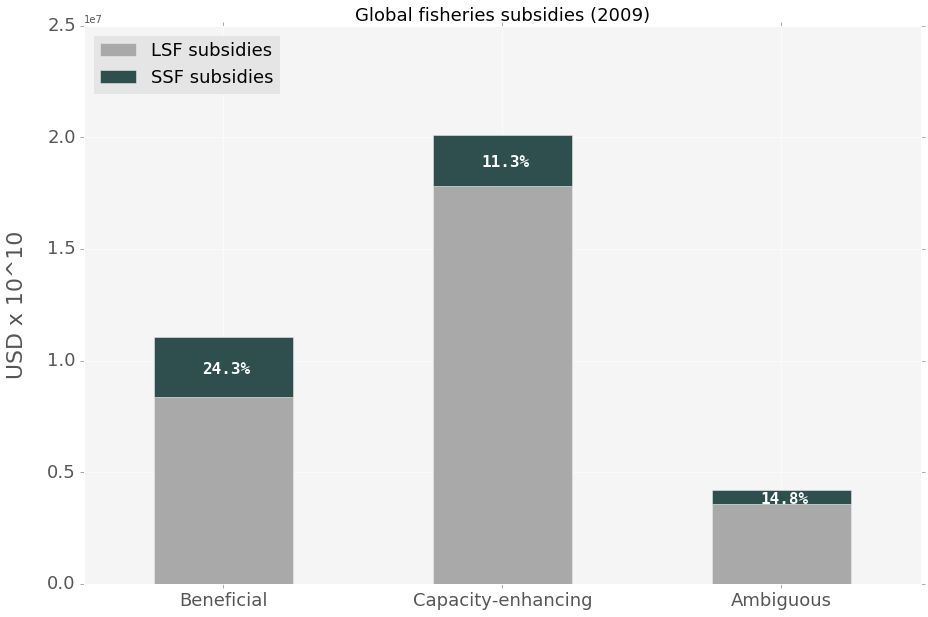

In [26]:


data = Subsidies_per_Category_short[['LSF subsidies','SSF subsidies']]
data_dict = data.to_dict()


# these percentages are the SSF percent out of the total subsidies calculated in Subsidies_per_Category['SSF percent']
SSFpercent = (
    {'label': 'Beneficial', 'percentage': 24.3}, 
    {'label': 'Capacity-enhancing', 'percentage': 11.3},
    {'label': 'Ambiguous', 'percentage': 14.8}
)

# add totals to SFFpercent
for key, val in data_dict.items():
    for k, v in data_dict[key].items():
        for i in SSFpercent:
            if i['label'] == k:
                if 'total' in i.keys():
                    i['total'] += v
                else:
                    i['total'] = v

# print("data_dict {}".format(data_dict))


# create subplot
ax = data.plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=18, color=["darkgray","darkslategrey"])
ax.set_title("Global fisheries subsidies (2009)", fontsize=18)
ax.set_ylabel("USD x 10^10",fontsize=22)
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(['Beneficial','Capacity-enhancing','Ambiguous'],rotation=360, fontsize=18)
ax.set_axis_bgcolor('0.96')
ax.yaxis.labelpad = 20

# get an ordered list of percentages
percentages = []
for item in SSFpercent:
    for k, v in item.items():
        if k == 'percentage':
            percentages.append(v)

# prepare rects
N = len(SSFpercent)
indexes = np.arange(N)
width = 0.02
rects = ax.bar(indexes, percentages, width)

# iterate rects and map index with SSF percentage
for index, rect in enumerate(rects):
    SSFpercent[index]['rect_x'] = rect.get_x() 


# now we have a single object holding 
# all the values we need to label the chart 
for bar in SSFpercent:
    #  get percenatage label as a string
    percentage = bar['percentage']
    #  get value of to of bar
    height = bar['total']
    label_position = height - ((height / 100 * percentage) / 2)
    #  position text lables
    ax.text(
        bar['rect_x'] + width/2,
        label_position  - 12.4**5, str(percentage) + '%',
        ha="center",
        family="monospace",
        fontsize=16,
        fontweight="bold",
        color="white"
    )


plt.savefig('Subsidies_Category.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Category.pdf', dpi=400, bbox_inches='tight')
plt.legend(loc=2,fontsize=18)
plt.show()

In [27]:
Subsidies_per_Category['SSF percent'] = Subsidies_per_Category['SSF subsidies']/Subsidies_per_Category['total_subsidies']*100
Subsidies_per_Category_billions = Subsidies_per_Category.loc[:,['LSF subsidies','SSF subsidies','SSF percent']]
Subsidies_per_Category_billions['LSF subsidies'] = Subsidies_per_Category_billions['LSF subsidies']/1000000
Subsidies_per_Category_billions['SSF subsidies'] = Subsidies_per_Category_billions['SSF subsidies']/1000000
Subsidies_per_Category_billions = Subsidies_per_Category_billions.reindex(index=['Beneficial','Capacity-enhancing','Ambiguous'])
Subsidies_per_Category_billions

,LSF subsidies,SSF subsidies,SSF percent
Category,,,
Beneficial,8.381,2.693,24.320
Capacity-enhancing,17.820,2.290,11.389
Ambiguous,3.565,0.621,14.828


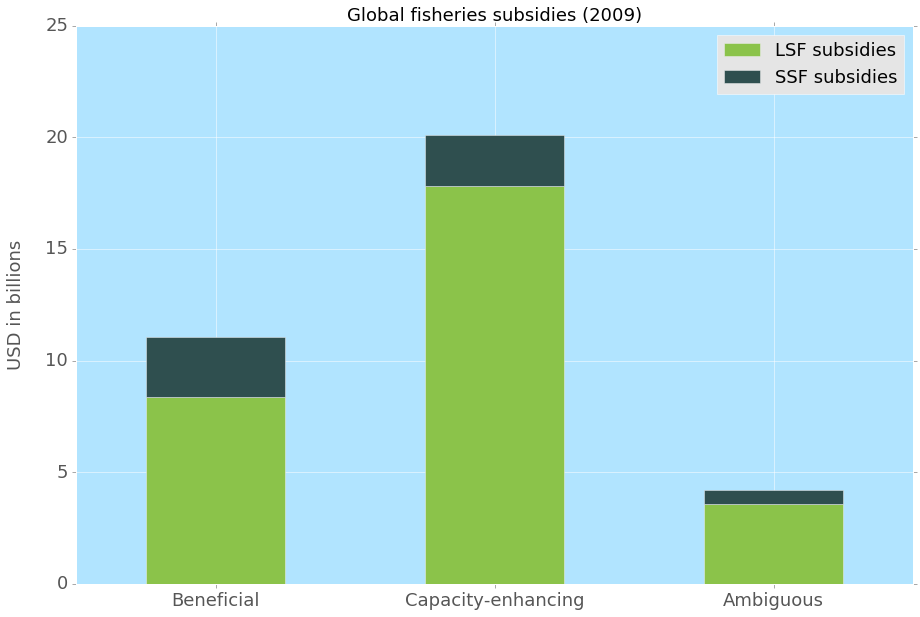

In [28]:
ax =Subsidies_per_Category_billions[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=18, color=['#8bc34a',"darkslategrey"])
ax.set_title("Global fisheries subsidies (2009)", fontsize=18)
ax.set_ylabel("USD in billions",fontsize=18)

ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(['Beneficial','Capacity-enhancing','Ambiguous'],rotation=0, fontsize=18)
ax.set_axis_bgcolor('#B1E4FF')
plt.legend(loc='best',fontsize=18)
ax.yaxis.labelpad = 20
plt.savefig('Subsidies_Category1.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Categpry1.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
SSF_subsidies_estimates_assessed.columns.values

array(['RegionName', 'Subregion', 'Countries', 'CLon', 'CLat', 'SIDS',
       'TotPop', 'HDI', 'Developed', 'GDP', 'EU member', 'Category',
       'SubType', 'Type', 'EEZ', 'total_catch', 'total_subsidies',
       'SSF_catch_percent', 'SSF_subregion_catch',
       'subsidies_subregion_all', 'Factor', 'SSF_subsidies_estimates',
       'SSF_subsidies_estimates_big', 'SSF_estimates_corrected',
       'SSFsubsidies_assessed_percent', 'weighted_by_sectorsize',
       'Data_group', 'SSF_USD_1000', 'SSF_subsidies_percent',
       'SSF_subsidies_percent_all', 'SSF subsidies', 'LSF subsidies'], dtype=object)

In [30]:
SSF_subsidies_estimates_assessed.replace(to_replace='Developed', value=1)
SSF = SSF_subsidies_estimates_assessed.loc[[330],['Developed']]
SSF

,Developed
330,True


In [158]:
Subsidies_per_subtype = SSF_subsidies_estimates_assessed.groupby(['SubType']).sum()
Subsidies_per_subtype = Subsidies_per_subtype.sort_values(by=['total_subsidies'],ascending=False)

Subsidies_per_subtype['SSF percent'] = Subsidies_per_subtype['SSF subsidies']/Subsidies_per_subtype['total_subsidies']*100
Subsidies_per_subtype_billions = Subsidies_per_subtype.loc[:,['LSF subsidies','SSF subsidies','total_subsidies']]/1000000

Subsidies_per_subtype_millions = Subsidies_per_subtype.loc[:,['LSF subsidies','SSF subsidies','total_subsidies']]/1000

print Subsidies_per_subtype_millions['LSF subsidies']
Subsidies_per_subtype.to_csv('Subsidies_subtype.csv')


SubType
Fuel subsidies               7108.124
Fisheries mangt.             5302.854
Fishing port develop.        2737.833
Boat constsruct. & renov.    2796.037
Fishery R&D                  2120.237
Markt. & storage infrast.    2517.787
Vessel buyback               2076.165
Fisher assistance            1462.834
MPAs                          958.329
Tax exemption                 948.174
Fisheries dev. projects       774.967
Fishing access                937.279
Rural fisher communities       25.947
Name: LSF subsidies, dtype: float64


In [273]:
#table for the pie charts figure
subtype_table = Subsidies_per_subtype.loc[:,['LSF subsidies','SSF subsidies','total_subsidies']]
subtype_table['Total'] = subtype_table['total_subsidies']
subtype_table['Large-scale'] = subtype_table['LSF subsidies']
subtype_table['Small-scale'] = subtype_table['SSF subsidies']
subtype_table = subtype_table.loc[:,['Small-scale','Large-scale','Total']]
subtype_table.to_csv('subtype_table.csv')

In [123]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

In [ ]:
subtypes = ['Management','Research and Develop','MPAs',
'Port Develop','Boat construct','Fuel','Develop project','Market and storage','Tax exemption','Fishing access',
'Fisher assistance','Rural fisher communities','Vessel buyback']
ssf_subsidies = [1835,588,271,722,503,462,270,186,147,0,480,138,3]
data = {'ssf_subsidies':}

In [163]:

Subsidies_pie = Subsidies_per_subtype.loc[:,['LSF subsidies','SSF subsidies']]/1000
Subsidies_pie.to_csv("subsidies_pie.csv")


In [181]:
Subsidies_pie2 = pd.read_csv("subsidies_pie2.csv")
#  Subsidies_pie_dict =  Subsidies_pie2.to_dict()
Subsidies_pie2


,SubType,LSF subsidies,SSF subsidies
0,Fisheries mangt.,5303,1835
1,Fishery R&D,2120,588
2,MPAs,958,271
3,Fuel subsidies,7108,462
4,Fishing port develop.,2738,722
5,Boat constsruct. & renov.,2796,503
6,Markt. & storage infrast.,2518,186
7,Tax exemption,948,147
8,Fisheries dev. projects,775,270
9,Fishing access,937,0


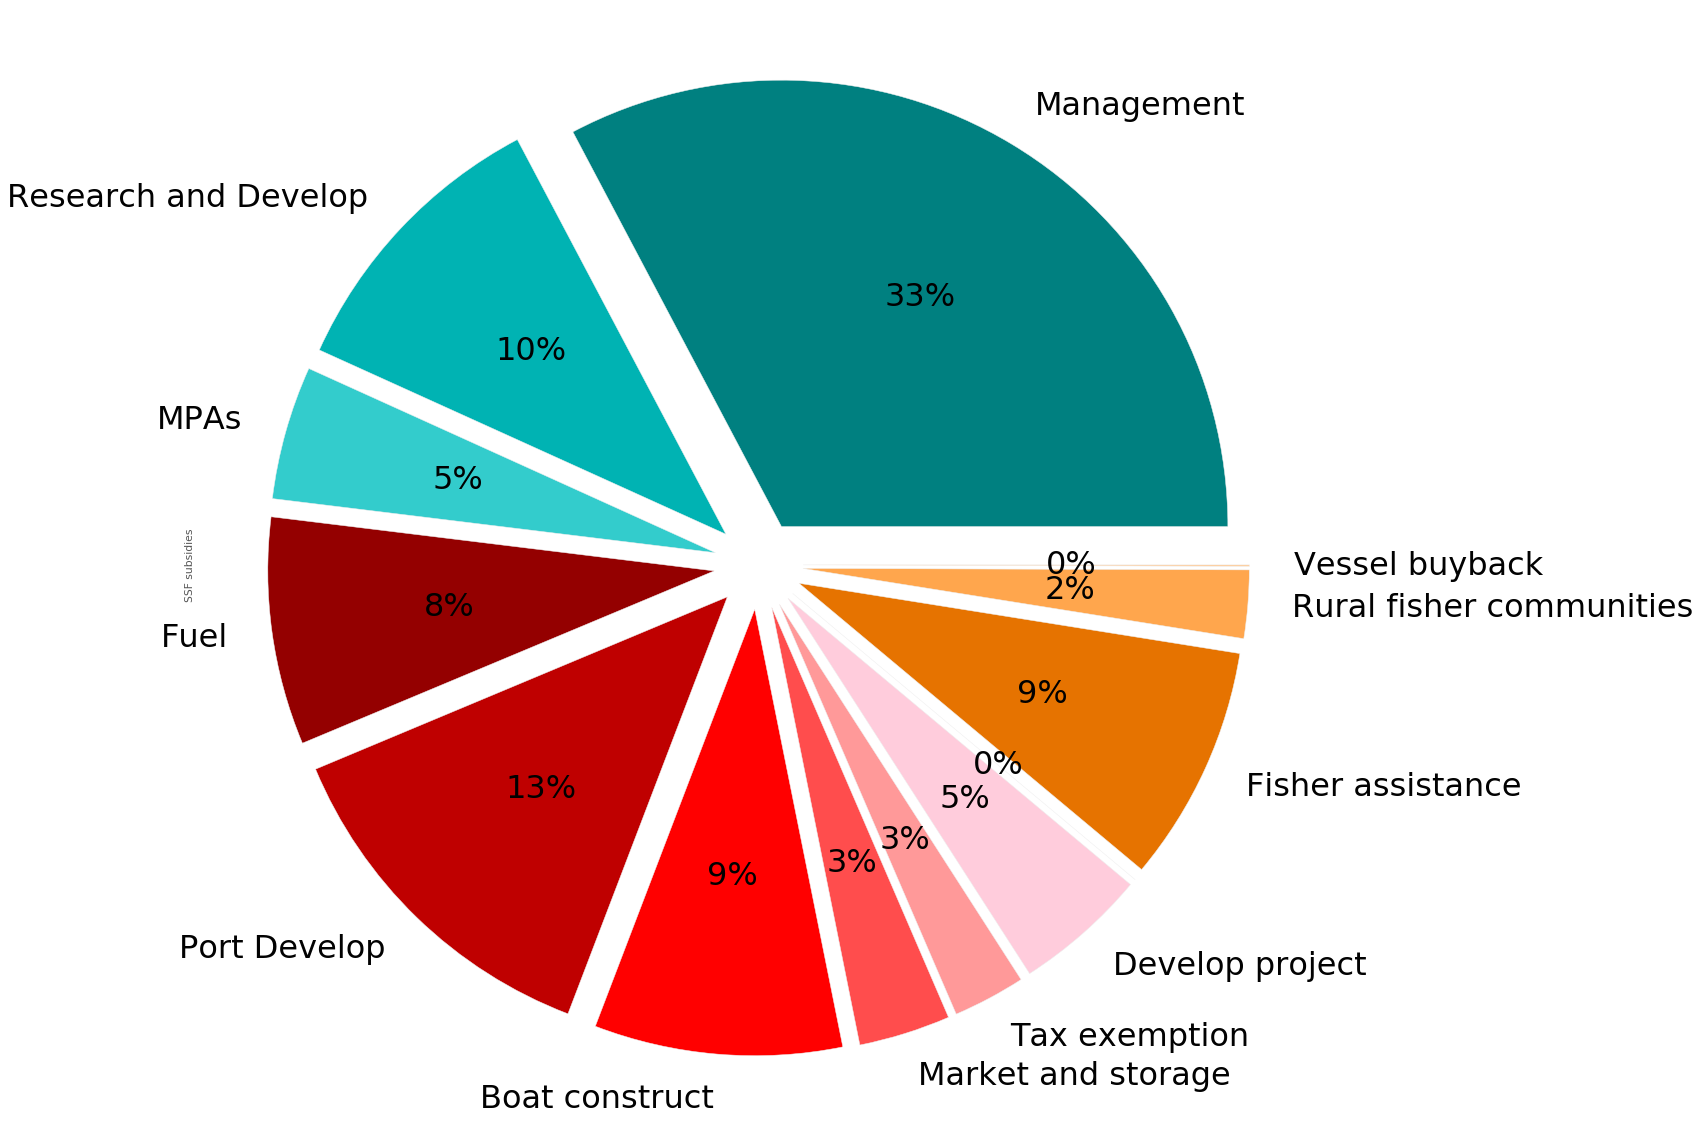

In [240]:

ax = Subsidies_pie2[['SSF subsidies']].plot(kind='pie',  subplots=True, legend=False, labels = [
        'Management','Research and Develop','MPAs','Fuel','Port Develop','Boat construct',
        'Market and storage','Tax exemption','Develop project','Fishing access','Fisher assistance',
        'Rural fisher communities', 'Vessel buyback'
    ], colors = [
        '#008080','#00b3b3','#33cccc','#940000','#bf0000','#ff0000','#ff4d4d','#ff9999','#ffccdc',
        '#ffb3b3','#e67300','#ffa64d','#ffcc99'
    ], autopct='%1.0f%%',fontsize=32, figsize=(20, 20), explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))





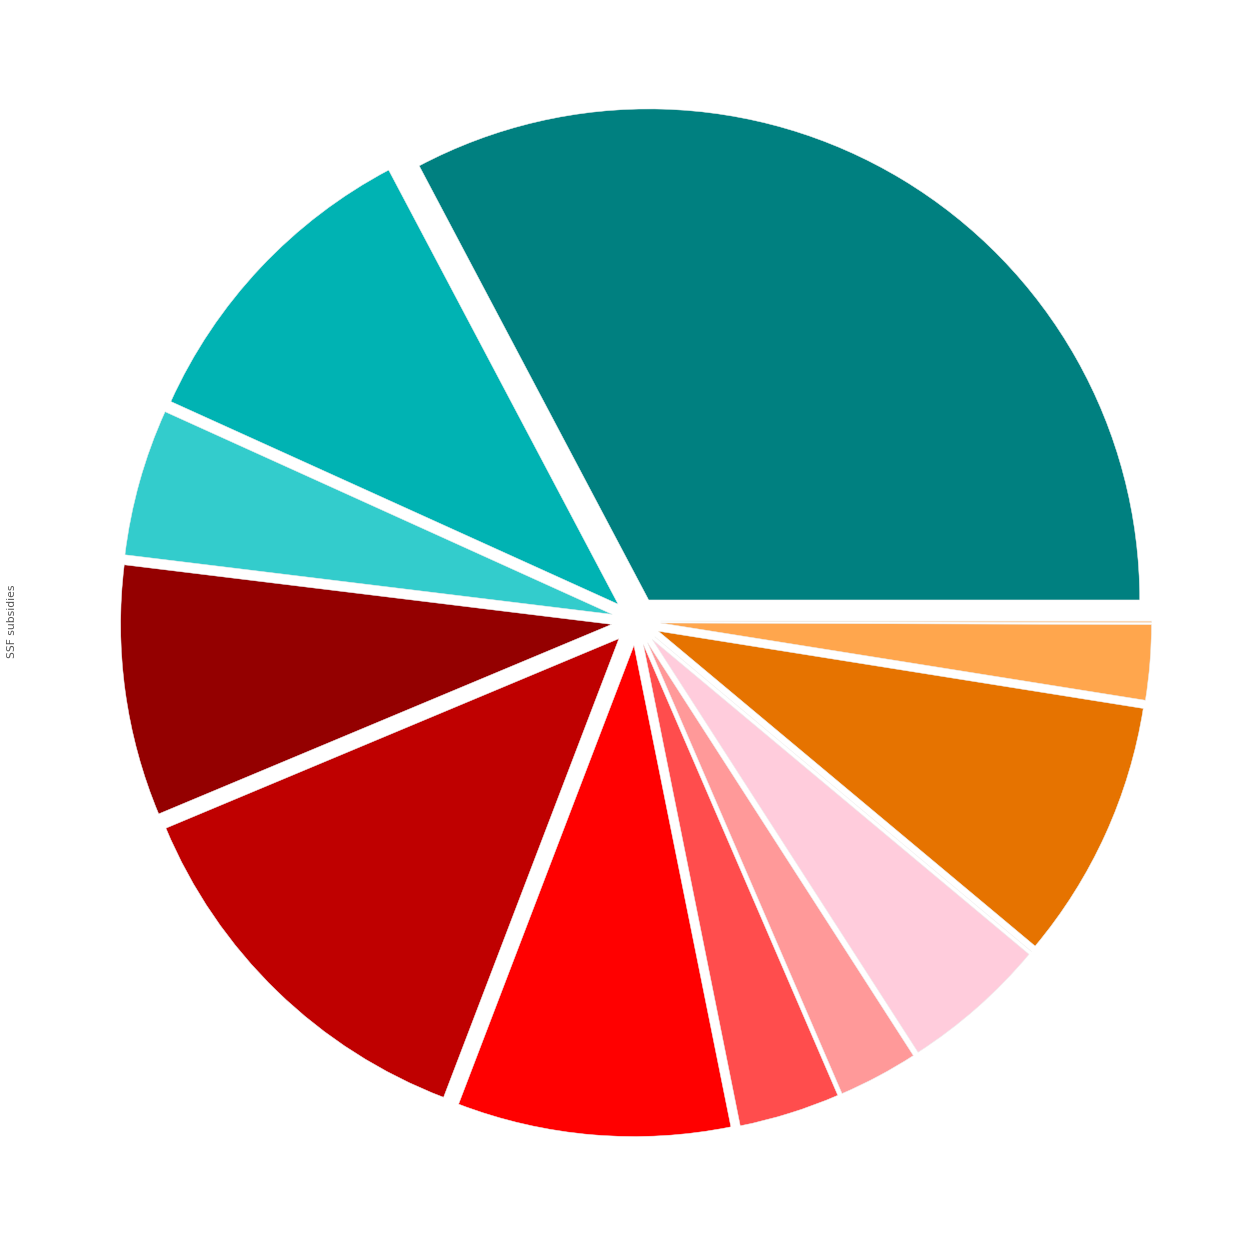

In [261]:

ax = Subsidies_pie2[['SSF subsidies']].plot(kind='pie',  subplots=True, legend=False, labels = None, colors = [
        '#008080','#00b3b3','#33cccc','#940000','#bf0000','#ff0000','#ff4d4d','#ff9999','#ffccdc',
        '#ffb3b3','#e67300','#ffa64d','#ffcc99'
    ],fontsize=32, figsize=(22, 22), explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05))

plt.savefig('Subsidies_SSF_pie.svg', dpi=400, bbox_inches='tight')

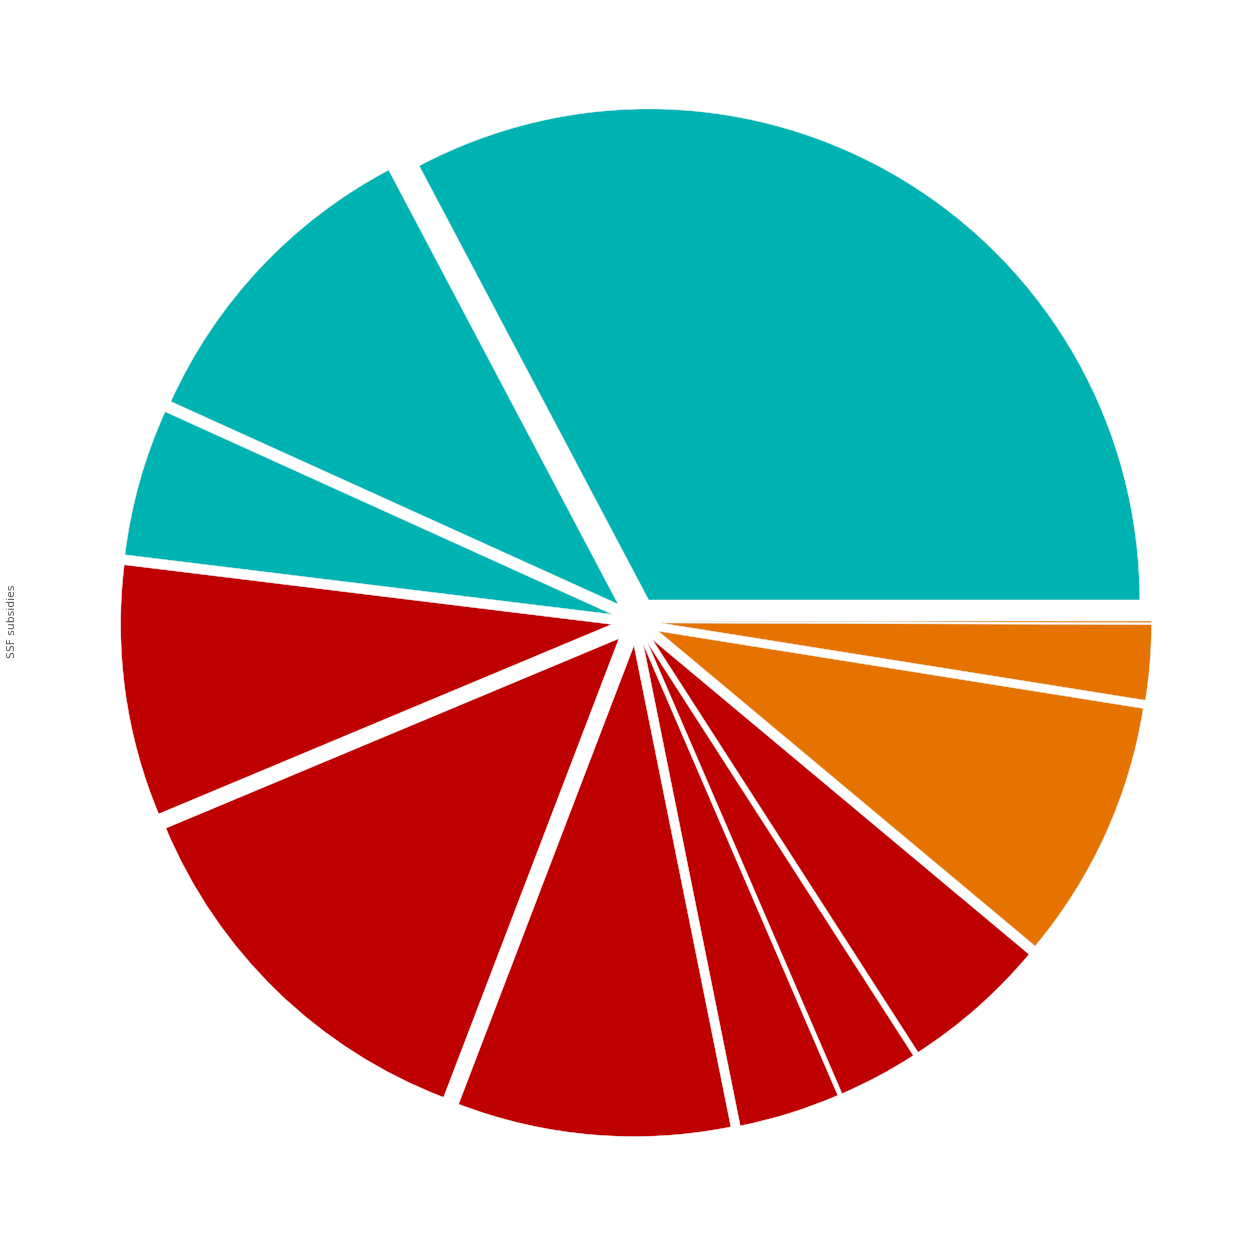

In [260]:

ax = Subsidies_pie2[['SSF subsidies']].plot(kind='pie',  subplots=True, legend=False, labels = None, colors = [
        '#00b3b3','#00b3b3','#00b3b3','#bf0000','#bf0000','#bf0000','#bf0000','#bf0000','#bf0000',
        '#bf0000','#e67300','#e67300','#e67300'
    ],fontsize=32, figsize=(22, 22), explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05))

plt.savefig('Subsidies_SSF_pie_color.svg', dpi=400, bbox_inches='tight')

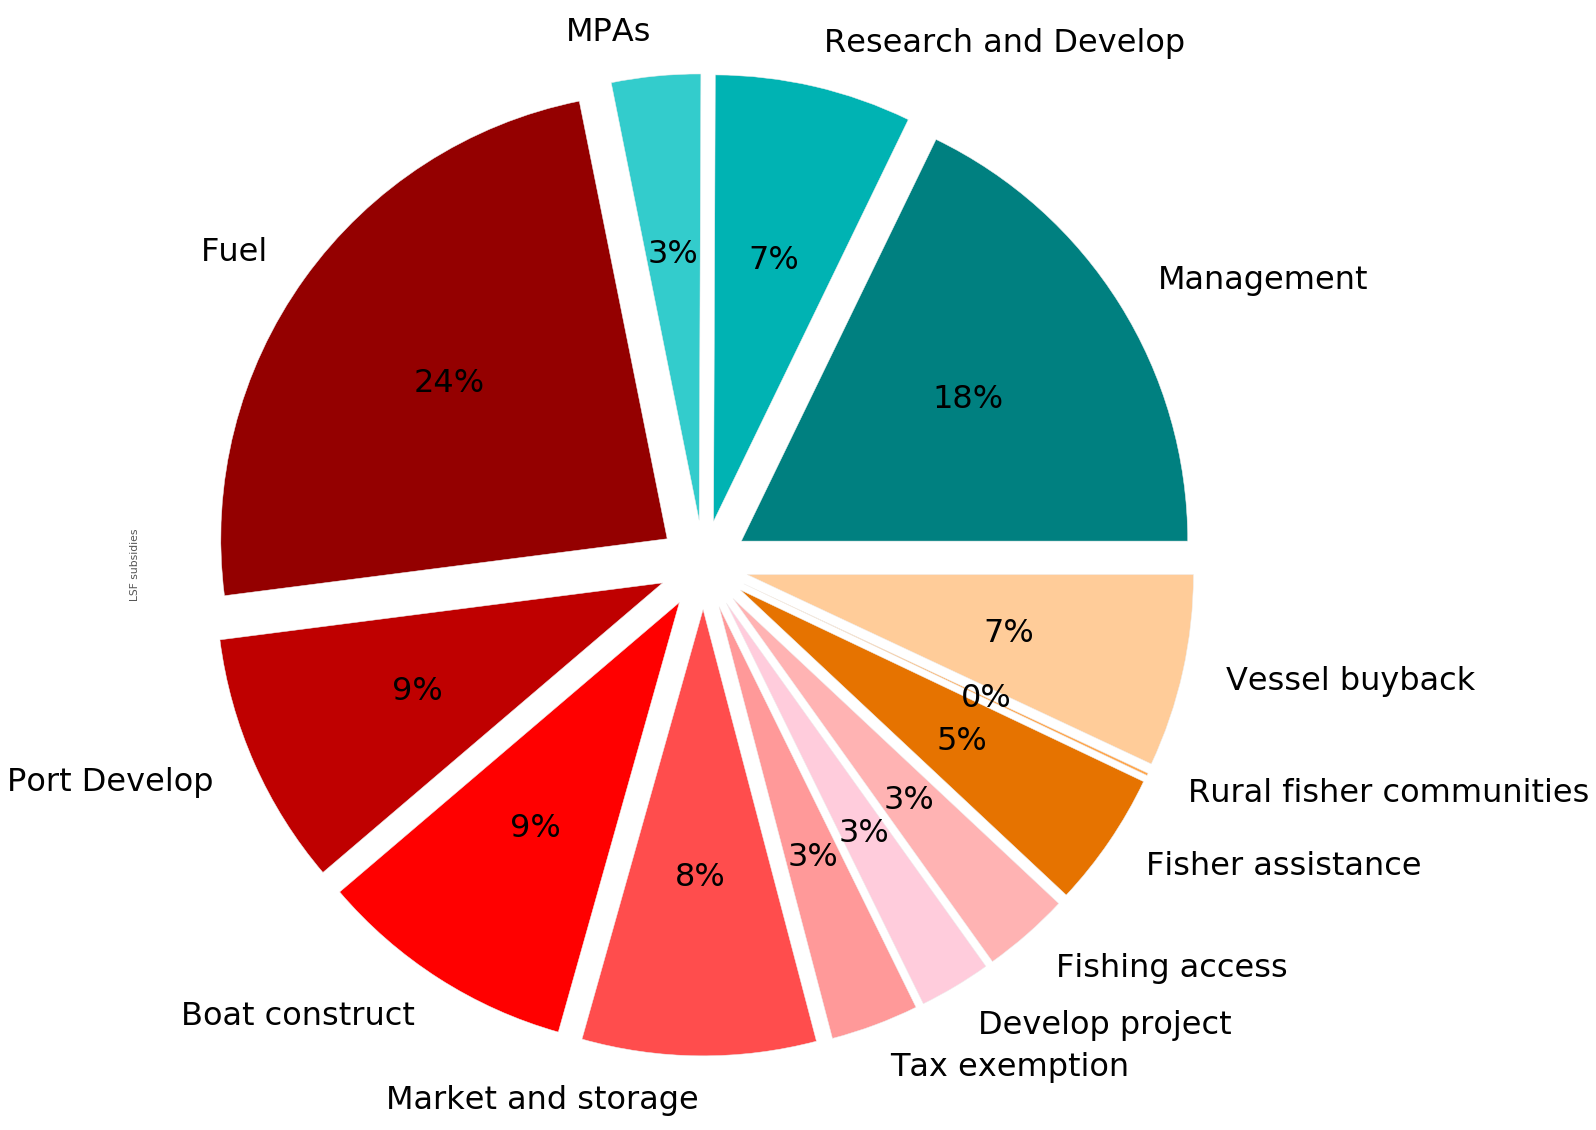

In [248]:

ax = Subsidies_pie2[['LSF subsidies']].plot(kind='pie',  subplots=True, legend=False, labels = [
        'Management','Research and Develop','MPAs','Fuel','Port Develop','Boat construct',
        'Market and storage','Tax exemption','Develop project','Fishing access','Fisher assistance',
        'Rural fisher communities', 'Vessel buyback'
    ], colors = [
        '#008080','#00b3b3','#33cccc','#940000','#bf0000','#ff0000','#ff4d4d','#ff9999','#ffccdc',
        '#ffb3b3','#e67300','#ffa64d','#ffcc99'
    ], autopct='%1.0f%%',fontsize=32, figsize=(20, 20), explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))




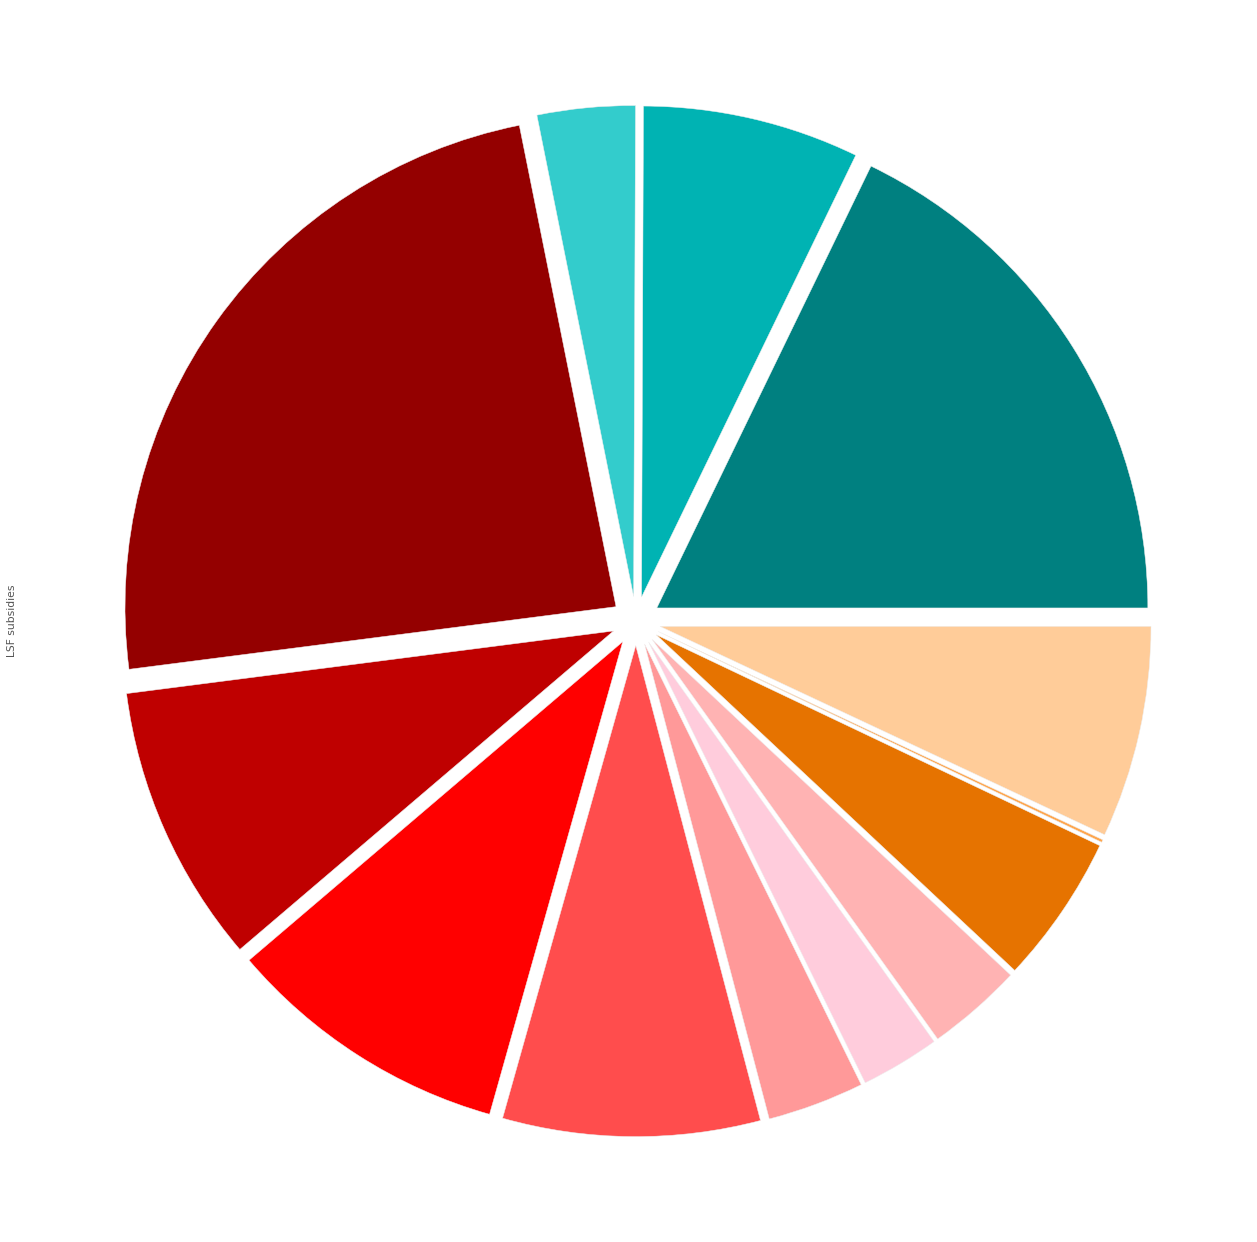

In [255]:

ax = Subsidies_pie2[['LSF subsidies']].plot(kind='pie',  subplots=True, legend=False, labels = None, colors = [
        '#008080','#00b3b3','#33cccc','#940000','#bf0000','#ff0000','#ff4d4d','#ff9999','#ffccdc',
        '#ffb3b3','#e67300','#ffa64d','#ffcc99'
    ],fontsize=32, figsize=(22, 22), explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05))

plt.savefig('Subsidies_LSF_pie.svg', dpi=400, bbox_inches='tight')

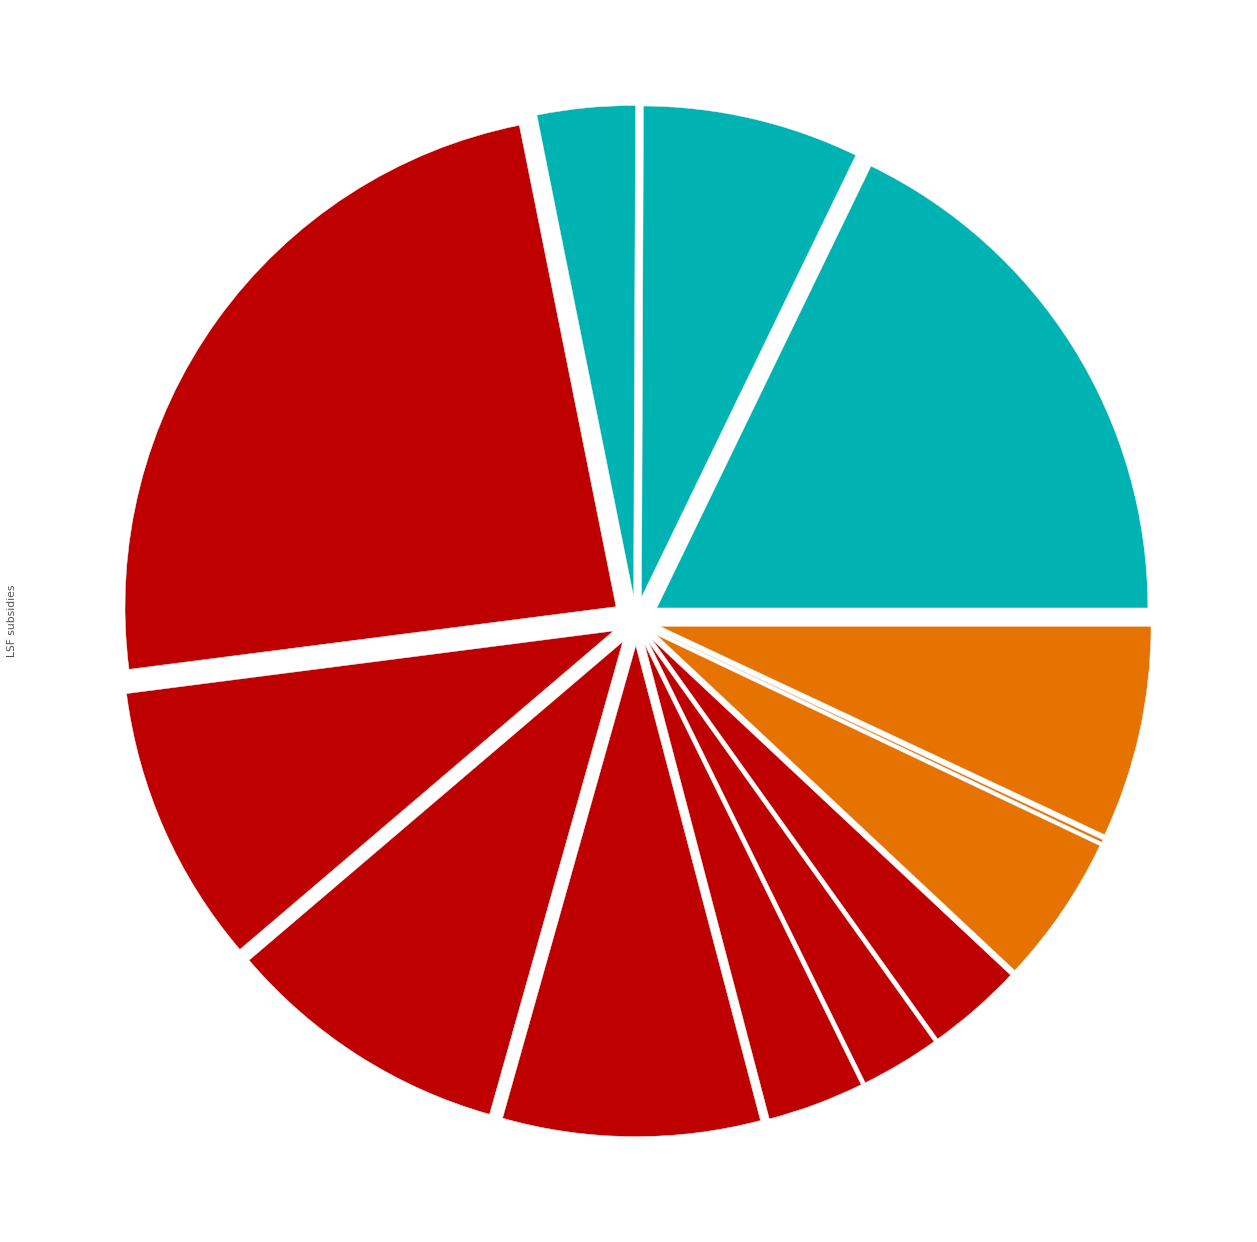

In [262]:

ax = Subsidies_pie2[['LSF subsidies']].plot(kind='pie',  subplots=True, legend=False, labels = None, colors = [
        '#00b3b3','#00b3b3','#00b3b3','#bf0000','#bf0000','#bf0000','#bf0000','#bf0000','#bf0000',
        '#bf0000','#e67300','#e67300','#e67300'
    ],fontsize=32, figsize=(22, 22), explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05))

plt.savefig('Subsidies_LSF_pie_color.svg', dpi=400, bbox_inches='tight')


        

In [200]:


fig = plt.figure('equal', figsize=(20,20), fontsize=18)

sizes = [1835,588,271,722,503,462,270,186,147,480,138,]
subtypes = ['Management','Research and Develop','MPAs',
            'Port Develop','Boat construct','Fuel','Develop project','Market and storage','Tax exemption',
            'Fisher assistance','Rural fisher communities'
           ]
colors = ['#194d19','#2c872c','#65cd65','#330000','#800000','#e60000','#ff3333','#ff6666','#ffb3b3','#e67300','#ffa64d']
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
ax = plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', labels=subtypes,
       shadow=False, startangle=90)
plt.savefig('Subsidies_Subtype_pie_SSF.svg', dpi=400, bbox_inches='tight')


TypeError: __init__() got an unexpected keyword argument 'fontsize'

(-1.0996519475722106,
 1.1024769815436406,
 -1.1587270991331309,
 1.0976091893605031)

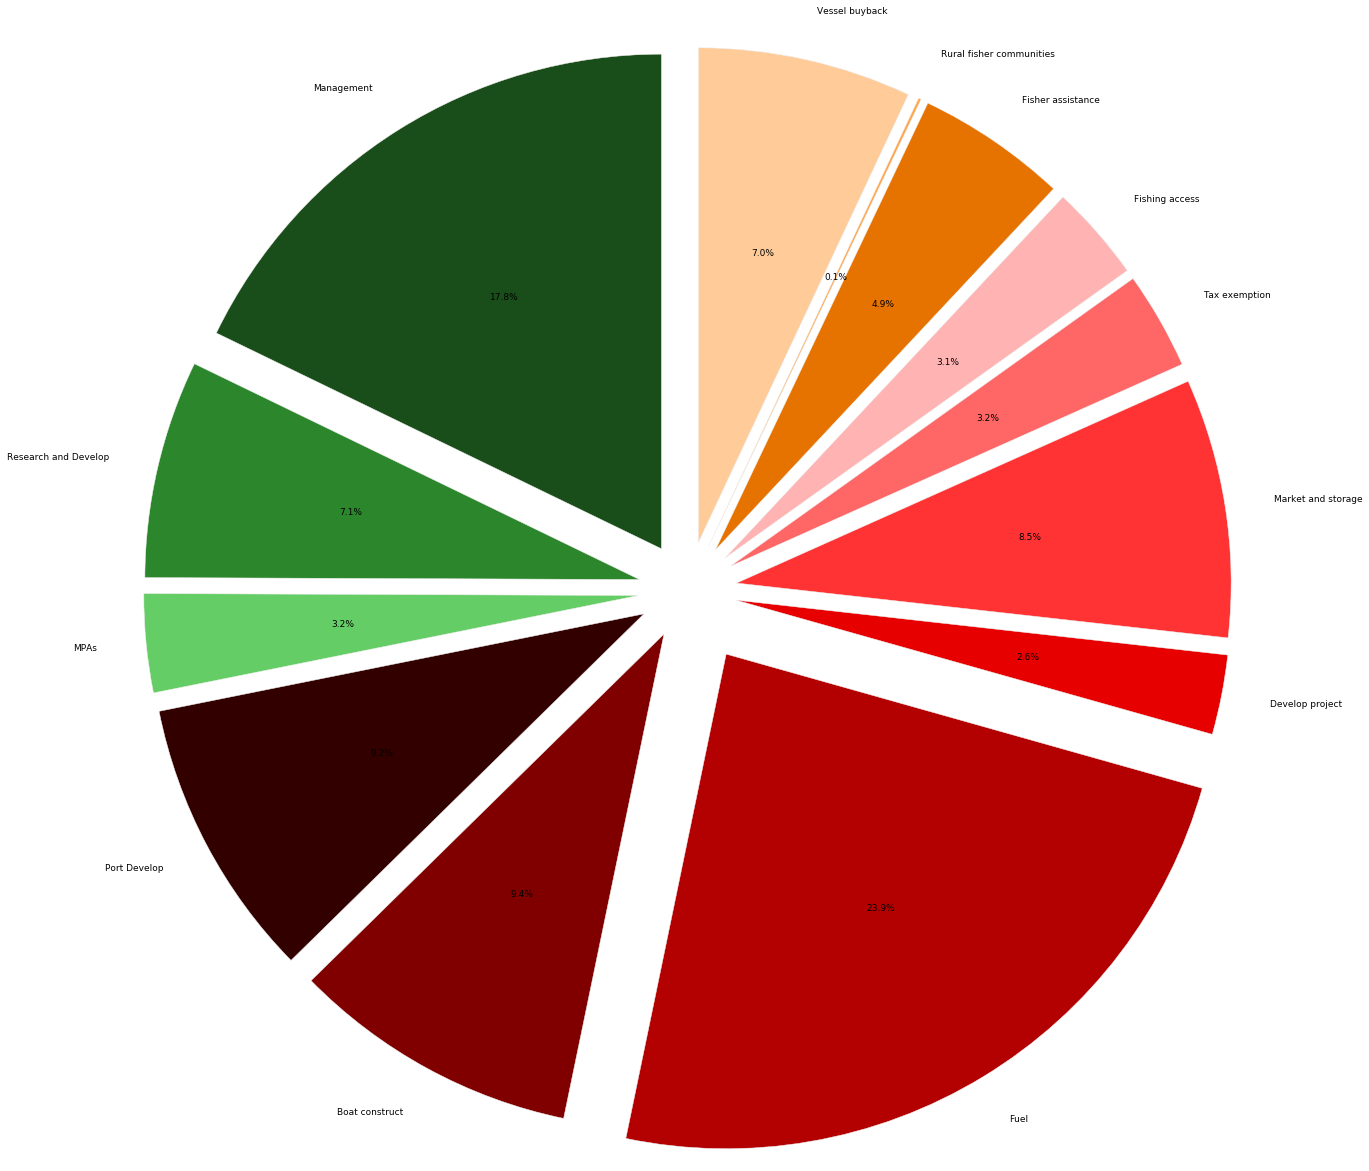

In [180]:

fig = plt.figure('equal', figsize=(20,20))

sizes = [5303,2120,958,2738,2796,7108,775,2518,948,937,1463,26,2076]
labels = ['Management','Research and Develop','MPAs',
'Port Develop','Boat construct','Fuel','Develop project','Market and storage','Tax exemption','Fishing access',
'Fisher assistance','Rural fisher communities','Vessel buyback']
colors = ['#194d19','#2c872c','#65cd65','#330000','#800000','#b30000','#e60000','#ff3333','#ff6666','#ffb3b3','#e67300','#ffa64d','#ffcc99']
explode = (0.1,0.1,0.1,0.1,0.1,0.15,0.1,0.1,0.1,0.1,0.1,0.1,0.1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')

In [33]:
print Subsidies_per_subtype['total_subsidies']/35371111.003*100
a = 3.460+3.299
b = (a/35.371111)*100
c = 0.722+0.503
d = (c/a)*100
c

SubType
Fuel subsidies               21.401
Fisheries mangt.             20.179
Fishing port develop.         9.782
Boat constsruct. & renov.     9.326
Fishery R&D                   7.657
Markt. & storage infrast.     7.645
Vessel buyback                5.880
Fisher assistance             5.492
MPAs                          3.474
Tax exemption                 3.097
Fisheries dev. projects       2.955
Fishing access                2.650
Rural fisher communities      0.462
Name: total_subsidies, dtype: float64


1.225

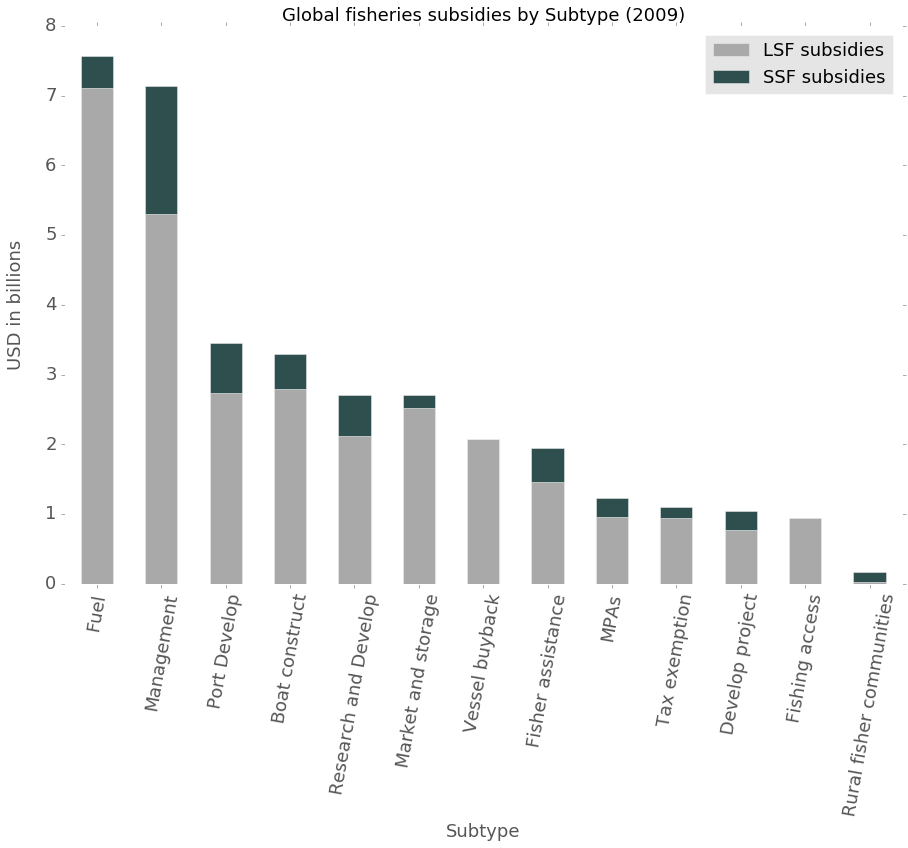

In [90]:
ax = Subsidies_per_subtype_billions[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(
        15,10),stacked=True, legend=True, fontsize=18, color=["darkgray","darkslategrey"] 
                                                                           )
ax.set_title("Global fisheries subsidies by Subtype (2009)", fontsize=18)
ax.set_ylabel("USD in billions",fontsize=18)
ax.yaxis.labelpad = 20
ax.set_xlabel("Subtype",fontsize=18)
ax.set_xticklabels(['Fuel', 'Management','Port Develop','Boat construct','Research and Develop','Market and storage','Vessel buyback','Fisher assistance','MPAs','Tax exemption','Develop project','Fishing access','Rural fisher communities'],rotation=80, fontsize=18)
ax.set_axis_bgcolor('w')
plt.legend(loc='best',fontsize=18)
plt.savefig('Subsidies_Subtype.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Subtype.pdf', dpi=400, bbox_inches='tight')

plt.show()

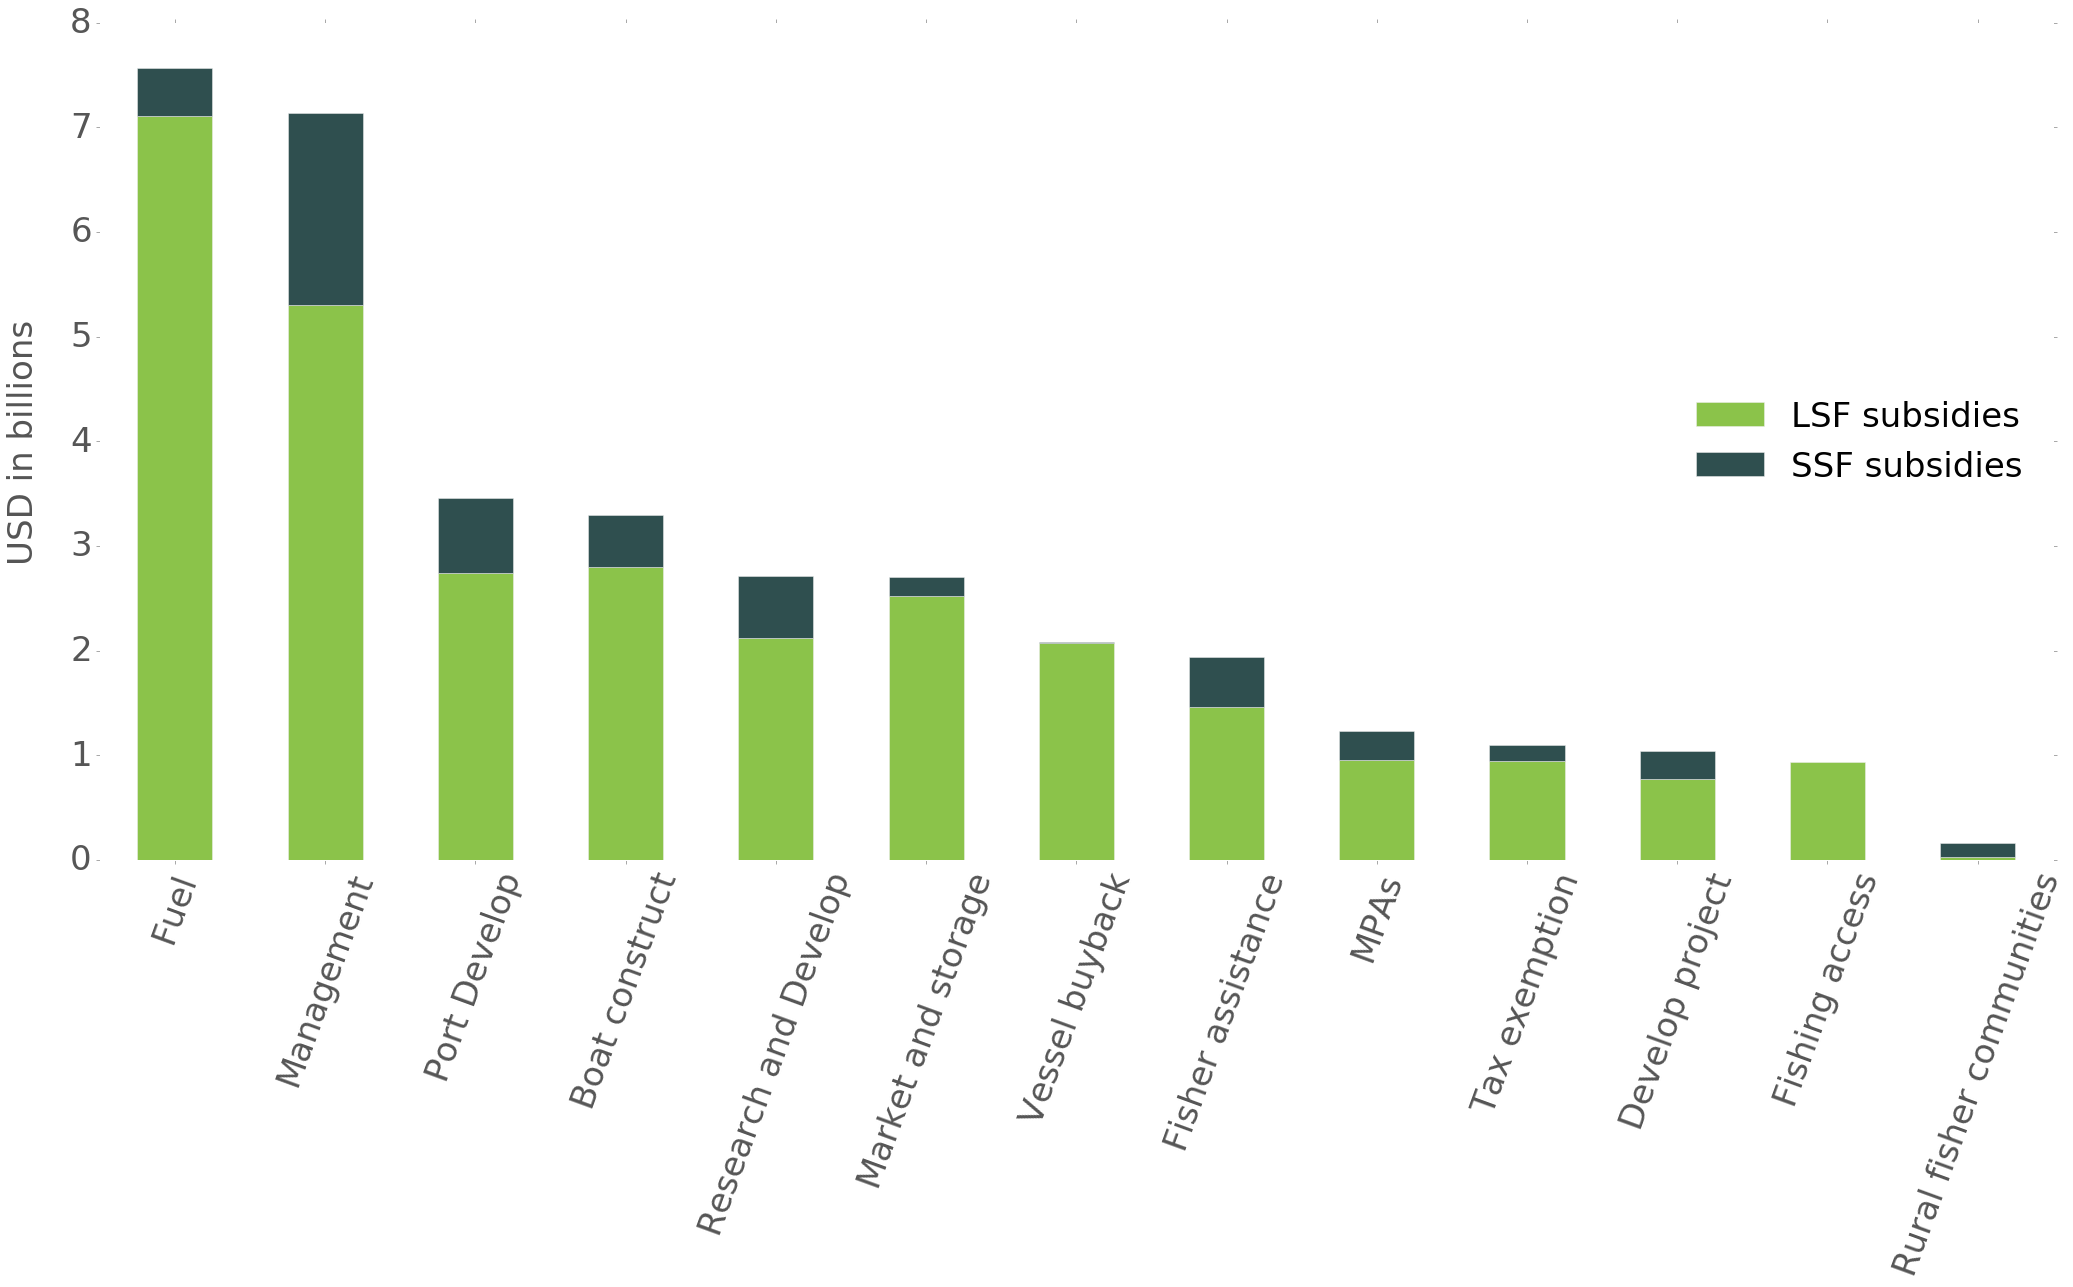

In [35]:
ax = Subsidies_per_subtype_billions[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(
        35,15),stacked=True, legend=True, fontsize=34, color=['#8bc34a',"darkslategrey"] 
                                                                           )

ax.set_ylabel("USD in billions",fontsize=34)
ax.yaxis.labelpad = 30
ax.set_xlabel("",fontsize=34)
ax.set_xticklabels(['Fuel', 'Management','Port Develop','Boat construct','Research and Develop','Market and storage',
                    'Vessel buyback','Fisher assistance','MPAs','Tax exemption','Develop project','Fishing access','Rural fisher communities'],rotation=70, fontsize=34)
ax.set_axis_bgcolor('w')
legend = plt.legend(loc=5,fontsize=34)
legend.get_frame().set_facecolor('w')
plt.savefig('Subsidies_Subtype_colour.svg', dpi=800, bbox_inches='tight')
plt.savefig('Subsidies_Subtype_colour.pdf', dpi=800, bbox_inches='tight')

plt.show()

In [36]:
Subtypes = Subsidies_per_subtype.loc[:,['SSF percent', 'SSF subsidies','total_subsidies']]
Subtypes.to_csv('subtypes.csv')

In [37]:
Developed_subtype = SSF_subsidies_estimates_assessed.groupby(['SubType','Developed']).sum()

Developed_short = Developed_subtype.loc[:,['SSF subsidies']]
Developed = Developed_short.reset_index()

Developed_pivot = Developed.pivot_table(['SSF subsidies'], index=['SubType'], columns='Developed')

Developed_grouped = Developed.groupby(['Developed','SubType']).sum()


Developed_stacked = Developed_grouped.stack()
Developed_stacked
Developed_pivot.to_csv('Developed_pivot.csv')
Developed_sorted = pd.read_csv('Developed_pivot_sorted.csv')
Developed_sorted = Developed_sorted.rename(columns={'Developing':'Developing countries', 'Developed':'Developed countries'})
print Developed_pivot
#  Developed_pivot['Total'] = Developed_pivot['False'] + Developed_pivot['True']
np.sum(Developed_pivot['SSF subsidies'])

                          SSF subsidies             
Developed                         False        True 
SubType                                             
Boat constsruct. & renov.    252162.383   250510.751
Fisher assistance            102442.983   377134.600
Fisheries dev. projects      199274.184    71065.903
Fisheries mangt.             543203.222  1291419.630
Fishery R&D                  350632.016   237550.449
Fishing access                    0.000        0.000
Fishing port develop.         62933.470   659382.778
Fuel subsidies               246553.556   214981.631
MPAs                          82252.189   188365.685
Markt. & storage infrast.    104053.747    82327.723
Rural fisher communities     136397.493     1192.648
Tax exemption                 82300.613    64921.256
Vessel buyback                    0.000     3484.313


Developed
False    2162205.855
True     3442337.366
dtype: float64

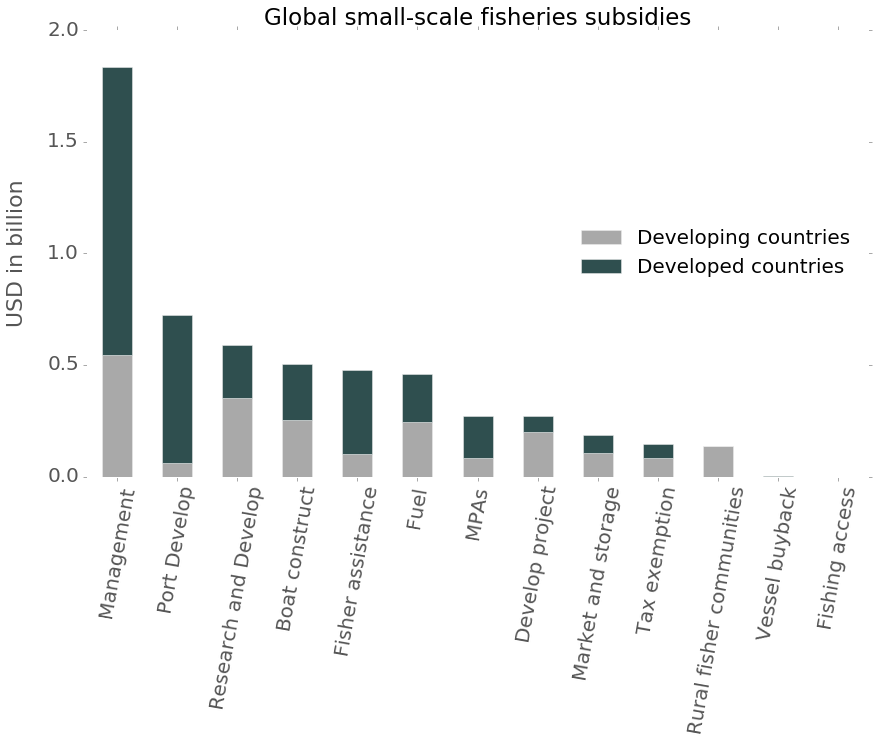

In [38]:
ax = Developed_sorted[['Developing countries','Developed countries']].plot(
    kind='bar', figsize=(14,8),stacked=True, legend=True, fontsize=20, color=["darkgray","darkslategrey"]
)
            
ax.set_title("Global small-scale fisheries subsidies", fontsize=23)
ax.set_titlepad = 100
ax.set_ylabel("USD in billion",fontsize=22)
ax.yaxis.labelpad = 20
ax.set_xlabel("",fontsize=18)

ax.set_xticklabels([
        'Management','Port Develop','Research and Develop','Boat construct','Fisher assistance','Fuel','MPAs',
        'Develop project','Market and storage','Tax exemption','Rural fisher communities','Vessel buyback','Fishing access'
    ],rotation=80, fontsize=20
                  )
ax.set_axis_bgcolor('w')

legend = plt.legend(loc=5,fontsize=20)
legend.get_frame().set_facecolor('w')

plt.savefig('Subsidies_Developed.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Developed.pdf', dpi=400, bbox_inches='tight')

plt.show()

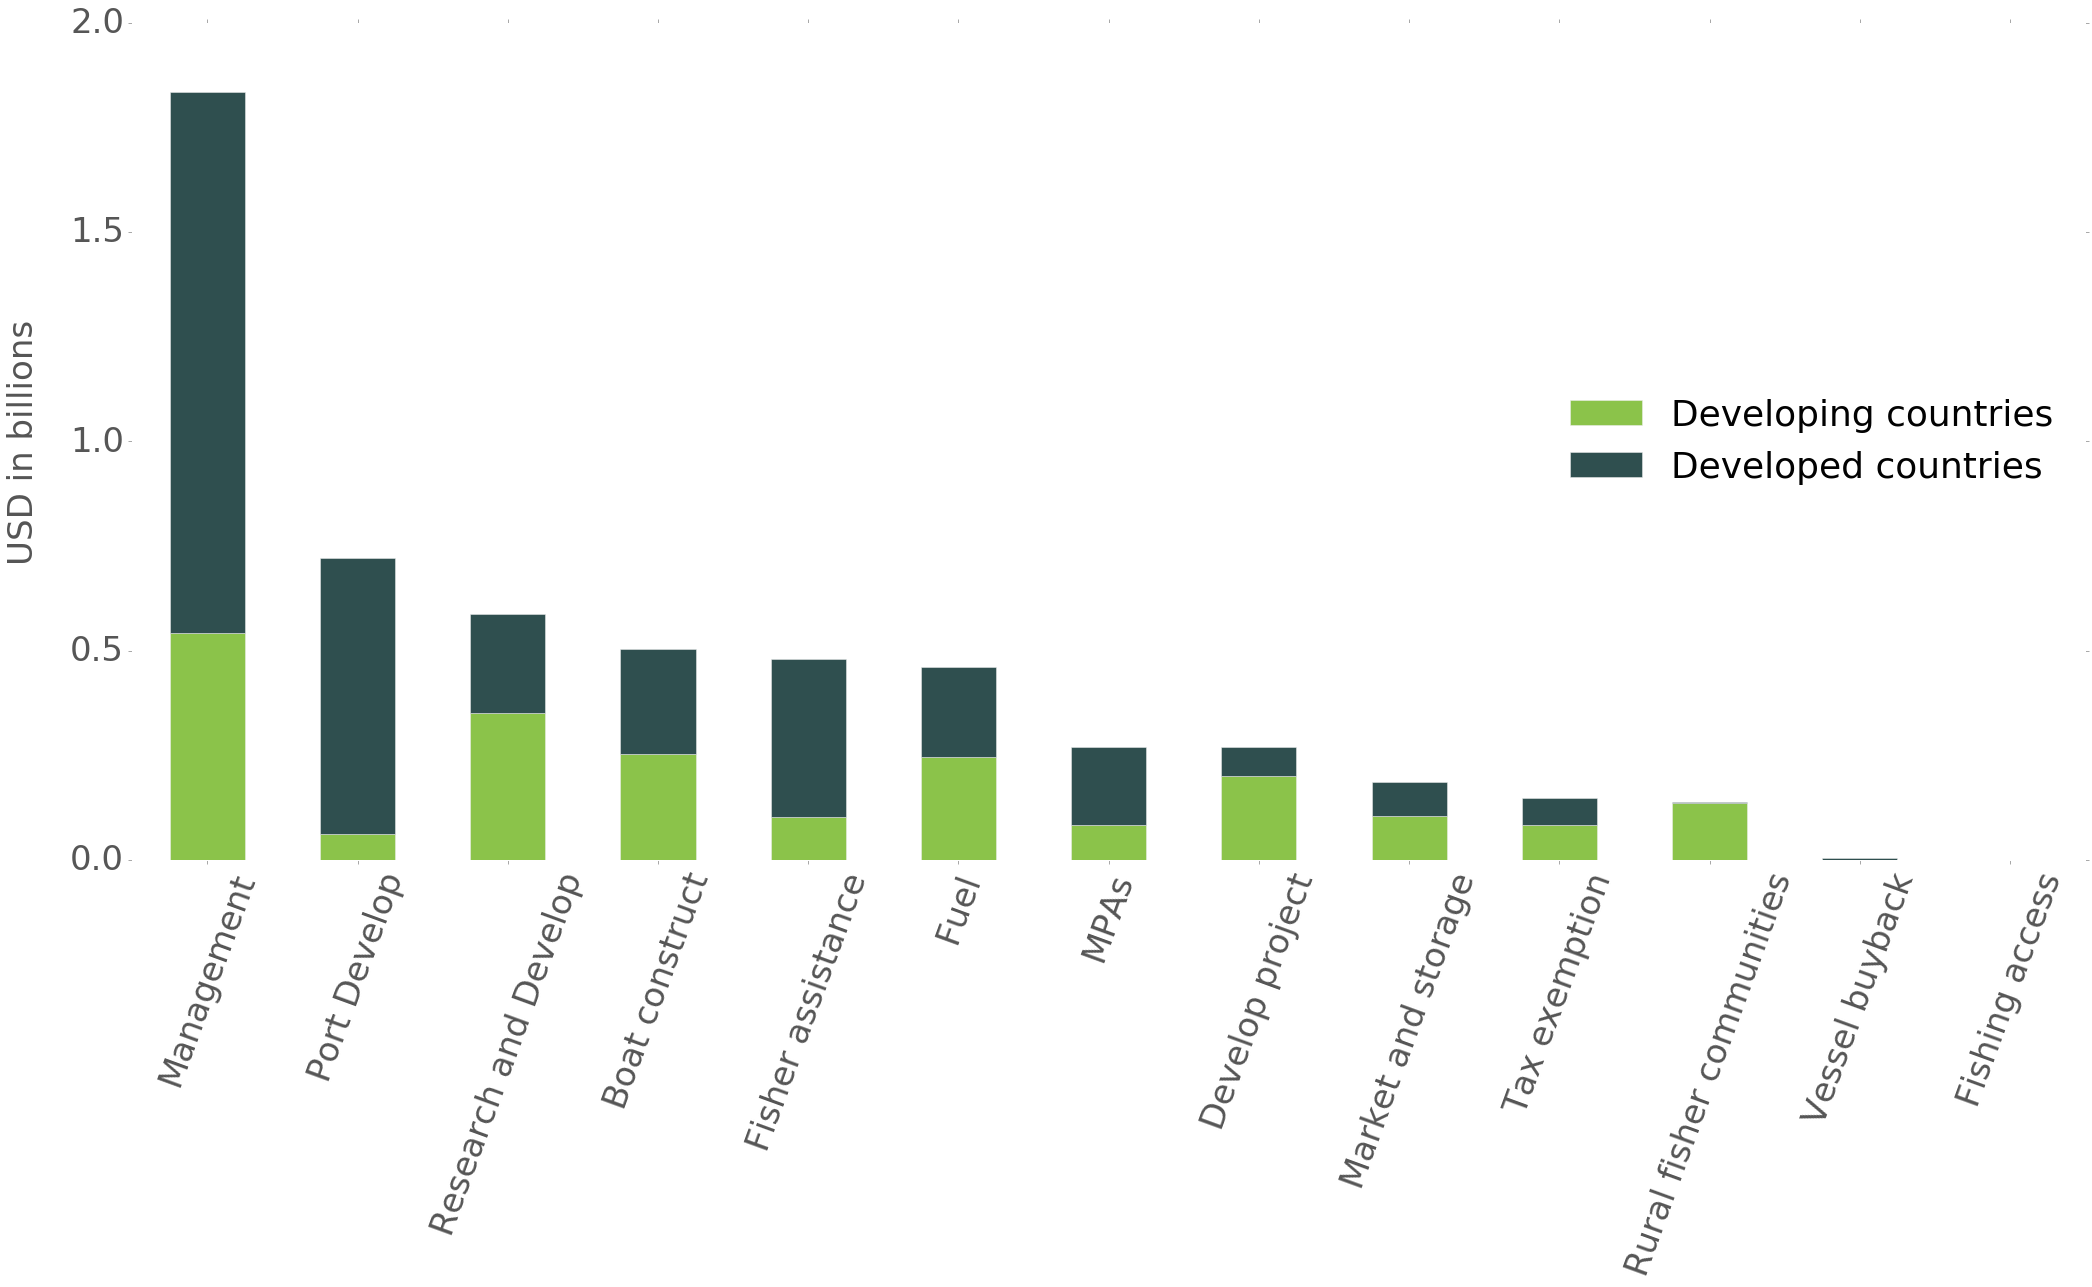

In [39]:
ax = Developed_sorted[['Developing countries','Developed countries']].plot(kind='bar', figsize=(
        35,15),stacked=True, legend=True, fontsize=34, color=['#8bc34a',"darkslategrey"] 
                                                                           )

ax.set_ylabel("USD in billions",fontsize=34)
ax.yaxis.labelpad = 30
ax.set_xlabel("",fontsize=34)
ax.set_xticklabels(['Management','Port Develop','Research and Develop','Boat construct','Fisher assistance','Fuel','MPAs',
        'Develop project','Market and storage','Tax exemption','Rural fisher communities','Vessel buyback','Fishing access'
    ],rotation=70, fontsize=34)
ax.set_axis_bgcolor('w')
legend = plt.legend(loc=5,fontsize=36)
legend.get_frame().set_facecolor('w')
plt.savefig('Subsidies_Developed_colour.svg', dpi=800, bbox_inches='tight')
plt.savefig('Subsidies_Developed_colour.pdf', dpi=800, bbox_inches='tight')

plt.show()

In [40]:
Developed_sorted['SSF_total'] = Developed_sorted['Developing countries']+Developed_sorted['Developed countries']
Developed_sorted['developing_percent'] = Developed_sorted['Developing countries']/Developed_sorted['SSF_total']*100
print Developed_sorted

                      SubType  Developing countries  Developed countries  \
0            Fisheries mangt.                 0.543                1.291   
1       Fishing port develop.                 0.063                0.659   
2                 Fishery R&D                 0.351                0.238   
3   Boat constsruct. & renov.                 0.252                0.251   
4           Fisher assistance                 0.102                0.377   
5              Fuel subsidies                 0.247                0.215   
6                        MPAs                 0.082                0.188   
7     Fisheries dev. projects                 0.199                0.071   
8   Markt. & storage infrast.                 0.104                0.082   
9               Tax exemption                 0.082                0.065   
10   Rural fisher communities                 0.136                0.001   
11             Fishing access                 0.000                0.003   
12          

In [41]:
#  add another row to have a total value for developed and developing countries
#  calculate percentage for both developed and devleoping per subtype
Developed_sorted1 = Developed_sorted.append(Developed_sorted.sum(numeric_only=True), ignore_index=True)
Developed_sorted1['total'] = Developed_sorted1['Developing countries'] + Developed_sorted1['Developed countries']
Developed_sorted1['percent developed'] = Developed_sorted1['Developed countries'] / Developed_sorted1['total']*100
Developed_sorted1['percent developing'] = Developed_sorted1['Developing countries'] / Developed_sorted1['total']*100

Developed_sorted2 = Developed_sorted

In [42]:
Developed_category = SSF_subsidies_estimates_assessed.groupby(['Category','Developed']).sum()

DevelopedC_short = Developed_category.loc[:,['SSF subsidies']]

print np.sum(DevelopedC_short['SSF subsidies'])

DevelopedC_short['SSF subsidies'] = DevelopedC_short['SSF subsidies']/1000000

DevelopedC = DevelopedC_short.unstack()
DevelopedC = DevelopedC.reindex(index=['Beneficial','Capacity-enhancing','Ambiguous'])
DevelopedC = DevelopedC.rename(columns={'SSF subsidies':'SSF'})
DevelopedC = DevelopedC.rename(columns={False:'Developing', True:'Developed'})

print DevelopedC


DevelopedC.to_csv('Developed_Category.csv')

#  DevelopedC_sorted = pd.read_csv('DevelopedC_pivot_sorted.csv')
#  DevelopedC_sorted = DevelopedC_sorted.rename(columns={'Developing':'Developing countries', 'Developed':'Developed countries'})
#  print Developed_pivot

Developed_sum = np.sum(DevelopedC['SSF'])

print Developed_sum

print

5604543.22107
                          SSF          
Developed          Developing Developed
Category                               
Beneficial              0.976     1.717
Capacity-enhancing      0.947     1.343
Ambiguous               0.239     0.382
Developed
Developing    2.162
Developed     3.442
dtype: float64



In [43]:
DevelopedC_total = Developed_category.loc[:,['total_subsidies']]
print np.sum(DevelopedC_total['total_subsidies'])

DevelopedC_total['total_subsidies'] = DevelopedC_total['total_subsidies']/1000000

Developedtotal = DevelopedC_total.unstack()
Developedtotal = Developedtotal.reindex(index=['Beneficial','Capacity-enhancing','Ambiguous'])
Developedtotal = Developedtotal.rename(columns={'total_subsidies':'total'})
Developedtotal = Developedtotal.rename(columns={False:'Developing', True:'Developed'})


print Developedtotal
print np.sum(Developedtotal['total'])

35371111.0032
                        total          
Developed          Developing Developed
Category                               
Beneficial              3.686     7.389
Capacity-enhancing      8.155    11.956
Ambiguous               0.464     3.722
Developed
Developing    12.304
Developed     23.067
dtype: float64


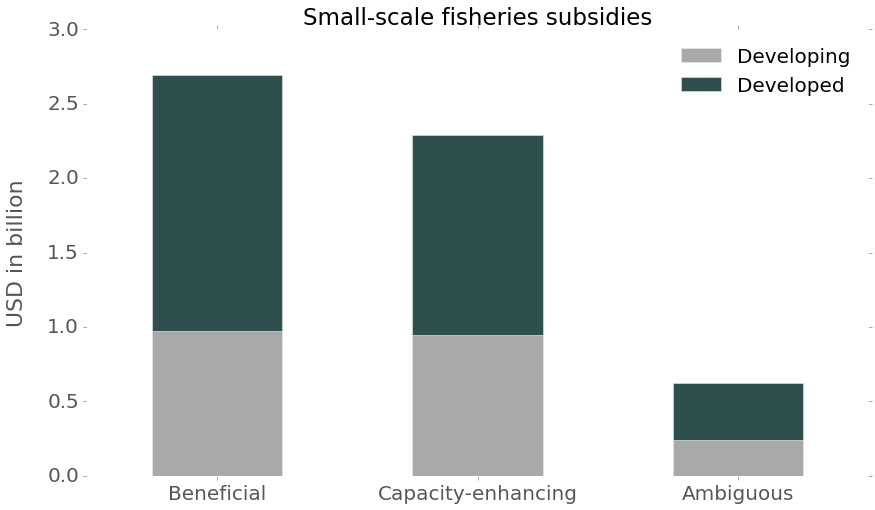

In [44]:
ax = DevelopedC.plot(
    kind='bar', figsize=(14,8),stacked=True, legend=[
        'Developed','Developing'], fontsize=20, color=["darkgray","darkslategrey"]
                    )
            
ax.set_title("Small-scale fisheries subsidies", fontsize=23)
ax.set_titlepad = 100
ax.set_ylabel("USD in billion",fontsize=22)
ax.yaxis.labelpad = 20
ax.set_xlabel("",fontsize=18)

ax.set_xticklabels(['Beneficial','Capacity-enhancing','Ambiguous'],rotation=0, fontsize=20)
ax.set_axis_bgcolor('w')

legend = plt.legend(['Developing','Developed'],loc='best',fontsize=20)
legend.get_frame().set_facecolor('w')


plt.savefig('Subsidies_DevelopedC.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_DevelopedC.pdf', dpi=400, bbox_inches='tight')

plt.show()

In [45]:
305.0/138.0

2.210144927536232

In [46]:
SSF_subsidies_estimates_assessed.columns.values

array(['RegionName', 'Subregion', 'Countries', 'CLon', 'CLat', 'SIDS',
       'TotPop', 'HDI', 'Developed', 'GDP', 'EU member', 'Category',
       'SubType', 'Type', 'EEZ', 'total_catch', 'total_subsidies',
       'SSF_catch_percent', 'SSF_subregion_catch',
       'subsidies_subregion_all', 'Factor', 'SSF_subsidies_estimates',
       'SSF_subsidies_estimates_big', 'SSF_estimates_corrected',
       'SSFsubsidies_assessed_percent', 'weighted_by_sectorsize',
       'Data_group', 'SSF_USD_1000', 'SSF_subsidies_percent',
       'SSF_subsidies_percent_all', 'SSF subsidies', 'LSF subsidies'], dtype=object)

In [47]:
Subsidies_per_region = SSF_subsidies_estimates_assessed.groupby(['RegionName']).sum()
Subsidies_per_region['LSF subsidies'] = Subsidies_per_region['LSF subsidies']/1000000
Subsidies_per_region['SSF subsidies'] = Subsidies_per_region['SSF subsidies']/1000000
Subsidies_per_region = Subsidies_per_region.sort_values(by=['total_subsidies'],ascending=False)
Subsidies_per_region['SSF percent'] = (Subsidies_per_region['SSF subsidies']/(Subsidies_per_region['total_subsidies']/1000000)) *100
print Subsidies_per_region['total_subsidies']
print Subsidies_per_region['SSF percent'] 
print Subsidies_per_region['SSF subsidies']
print Subsidies_per_region['SSF subsidies']/np.sum(Subsidies_per_region['SSF subsidies'])*100
print Subsidies_per_region['LSF subsidies']/np.sum(Subsidies_per_region['LSF subsidies'])*100
print Subsidies_per_region['total_subsidies']/np.sum(Subsidies_per_region['total_subsidies'])*100

RegionName
Asia                                     15513598.568
Europe                                    8571364.858
North America                             5385147.020
Oceania                                   3319065.016
South, Central America and Carribbean     1690283.624
Africa                                     891651.916
Name: total_subsidies, dtype: float64
RegionName
Asia                                     19.489
Europe                                    7.002
North America                            18.998
Oceania                                   4.243
South, Central America and Carribbean    31.108
Africa                                   32.664
Name: SSF percent, dtype: float64
RegionName
Asia                                     3.023
Europe                                   0.600
North America                            1.023
Oceania                                  0.141
South, Central America and Carribbean    0.526
Africa                                   0.291
N

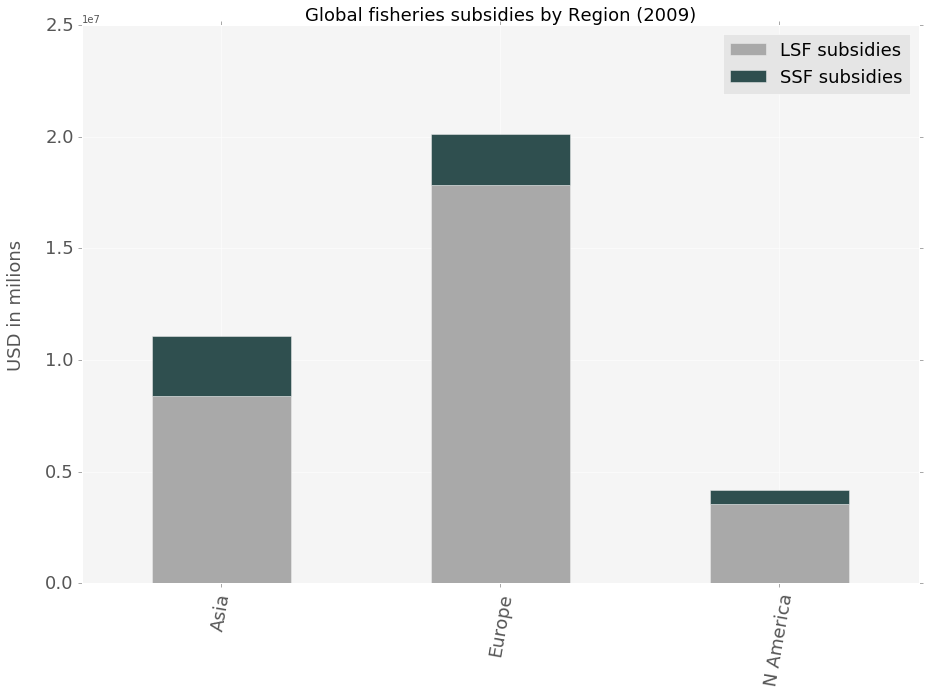

In [48]:
ax = data[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=18, color=["darkgray","darkslategrey"] )
ax.set_title("Global fisheries subsidies by Region (2009)", fontsize=18)
ax.set_ylabel("USD in milions",fontsize=18)
ax.yaxis.labelpad = 20
ax.set_xlabel("",fontsize=18)
ax.set_xticklabels(['Asia', 'Europe','N America','Oceania','S + C America,Carribbean', 'Africa'],rotation=80, fontsize=18)
ax.set_axis_bgcolor('0.96')
plt.legend(loc='best',fontsize=18)

plt.savefig('Subsidies_Region.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_Region.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [49]:
Subsidies_per_developed = SSF_subsidies_estimates_assessed.groupby(['Developed']).sum()
Subsidies_per_developed

,CLon,CLat,SIDS,TotPop,HDI,GDP,EU member,EEZ,total_catch,total_subsidies,...,SSF_subsidies_estimates,SSF_subsidies_estimates_big,SSF_estimates_corrected,SSFsubsidies_assessed_percent,Data_group,SSF_USD_1000,SSF_subsidies_percent,SSF_subsidies_percent_all,SSF subsidies,LSF subsidies
Developed,,,,,,,,,,,,,,,,,,,,,
False,19316.609,15789.526,455,52180446890,893.659,402298501815600,39,330,774341.1,12304224.252,...,614.18,220,479.286,12431.926,693,1883760.674,124.316,473.167,2162205.855,10142018.397
True,16431.901,18966.248,26,33573525102,460.395,878717203000000,260,123,645320.9,23066886.751,...,101.69,23,89.352,3329.532,530,3366048.696,33.300,89.520,3442337.366,19624549.385


In [50]:
Subsidies_per_developed['SSF_percent'] = Subsidies_per_developed['SSF subsidies']/Subsidies_per_developed['total_subsidies']*100
Subsidies_per_developed['SSF_percent']

Developed
False    17.573
True     14.923
Name: SSF_percent, dtype: float64

In [51]:
Subsidies_developed_category = SSF_subsidies_estimates_assessed.groupby(['Developed','Category']).sum()
Subsidies_developed_category['SSF_percent'] = Subsidies_developed_category['SSF subsidies']/Subsidies_developed_category['total_subsidies']*100
Subsidies_developed_category['SSF_percent']

Developed  Category          
False      Ambiguous             51.469
           Beneficial            26.484
           Capacity-enhancing    11.616
True       Ambiguous             10.259
           Beneficial            23.241
           Capacity-enhancing    11.234
Name: SSF_percent, dtype: float64

In [52]:
Subsidies_per_Subregion = SSF_subsidies_estimates_assessed.groupby(['Subregion']).sum()
#  print Subsidies_per_Subregion.loc[:,['total_subsidies']]

In [53]:
Subregions_all = Subsidies_per_Subregion.loc[:,['total_subsidies', 'SSF subsidies','LSF subsidies']]

Subregions_all_transposed = Subsidies_per_Subregion.loc[:,['SSF subsidies','LSF subsidies']].transpose()
Subregions_all_transposed

Subregion,Australia and New Zealand,Caribbean,Central America,Eastern Africa,Eastern Asia,Eastern Europe,Melanesia,Micronesia,Middle Africa,Northern Africa,...,Northern Europe,Polynesia,South America,Southeastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
SSF subsidies,81707.154,80804.980,98963.942,22860.814,1779574.794,102831.361,17696.877,40142.673,86691.916,39448.036,...,134323.266,1292.741,403795.383,649070.414,2730.181,389576.230,168741.547,139516.015,205423.778,194021.023
LSF subsidies,482993.694,31745.161,226120.646,31218.910,8980960.467,2794700.886,714246.512,1970637.761,93922.767,211636.079,...,2297746.889,10347.603,1040600.933,2582369.977,149951.417,662297.657,2026489.253,113675.781,268691.828,848144.056


In [54]:
#  Subsidies_per_Subregion['total_size'] = Subsidies_per_Subregion['total_subsidies']/100000
#  Subsidies_per_Subregion['total_size'] 
Subregions_all.to_csv('Subsidies_per_Subregion.csv')

In [55]:
#  Europe = SSF_subsidies_estimates_assessed.pivot_table(['total_subsidies','SSF subsidies','LSF subsidies'], index=None, columns='EU member')
Europe = SSF_subsidies_estimates_assessed.groupby(['EU member']).sum()
Europe = Europe.loc[[1],['LSF subsidies','SSF subsidies','total_subsidies']]
Europe['LSF subsidies'] = Europe['LSF subsidies']/1000000
Europe['SSF subsidies'] = Europe['SSF subsidies']/1000000
Europe['total_subsidies'] = Europe['total_subsidies']/1000000
Europe = Europe.rename(index={True:'EU'})

In [56]:
Europe

,LSF subsidies,SSF subsidies,total_subsidies
EU member,,,
EU,5.083,0.483,5.567


In [57]:
#  sorting and grouping data by largest fishing nations and political entities to prepare for a graph

Subsidies_countries = SSF_subsidies_estimates_assessed.groupby(['Countries']).sum()
print Subsidies_countries.columns.values

#  catch.groupby()
Subsidies_countries_fishing = Subsidies_countries.loc[['Japan','China','USA','Russian Fed','Indonesia'],['LSF subsidies','SSF subsidies','total_subsidies']]

Subsidies_countries_fishing['LSF subsidies'] = Subsidies_countries_fishing['LSF subsidies']/1000000
Subsidies_countries_fishing['SSF subsidies'] = Subsidies_countries_fishing['SSF subsidies']/1000000
Subsidies_countries_fishing['total_subsidies'] = Subsidies_countries_fishing['total_subsidies']/1000000

Subsidies_fishing = pd.concat([Subsidies_countries_fishing, Europe])


Subsidies_fishing = Subsidies_fishing.sort_values(by=['total_subsidies'], ascending = False)

print Subsidies_fishing

print np.sum(SSF_subsidies_estimates_assessed['LSF subsidies'])/1000000
print np.sum(SSF_subsidies_estimates_assessed['total_subsidies'])/1000000
print np.sum(SSF_subsidies_estimates_assessed['SSF subsidies'])/1000000


#  Subsidies_fishing.reindex_set[['Japan','China','USA','Russia','Indonesia','EU']]
#  Subsidies_countries = Subsidies_countries.sort_values(by=['total_subsidies'], ascending=False)

['CLon' 'CLat' 'SIDS' 'TotPop' 'HDI' 'Developed' 'GDP' 'EU member' 'EEZ'
 'total_catch' 'total_subsidies' 'SSF_catch_percent' 'SSF_subregion_catch'
 'subsidies_subregion_all' 'Factor' 'SSF_subsidies_estimates'
 'SSF_subsidies_estimates_big' 'SSF_estimates_corrected'
 'SSFsubsidies_assessed_percent' 'Data_group' 'SSF_USD_1000'
 'SSF_subsidies_percent' 'SSF_subsidies_percent_all' 'SSF subsidies'
 'LSF subsidies']
             LSF subsidies  SSF subsidies  total_subsidies
EU                   5.083          0.483            5.567
Japan                3.540          1.129            4.670
China                4.011          0.498            4.509
USA                  3.189          0.902            4.091
Russian Fed          2.245          0.055            2.300
Indonesia            0.570          0.056            0.627
29.7665677822
35.3711110032
5.60454322107


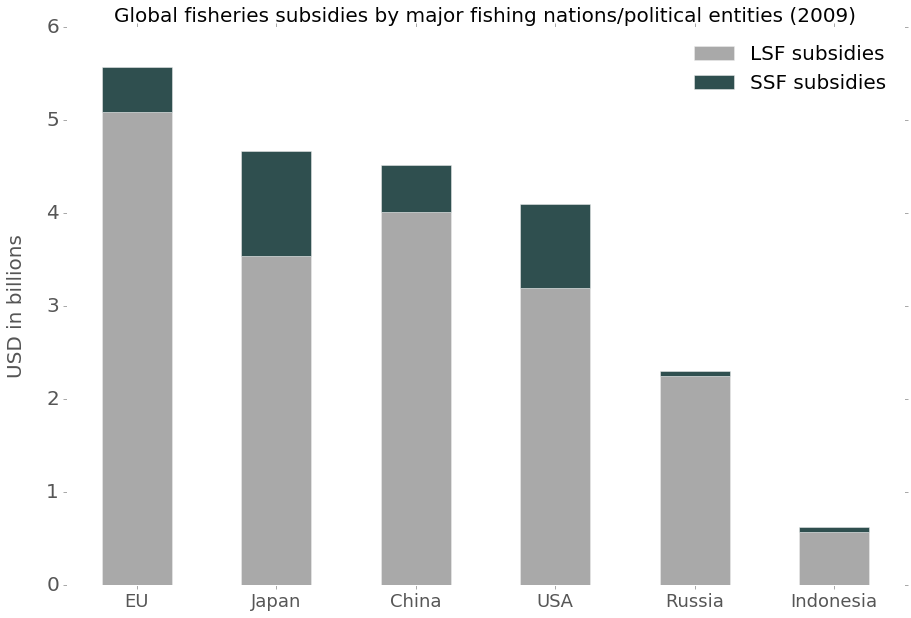

In [58]:
Subsidies_fishing
ax = Subsidies_fishing[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=20, color=["darkgray","darkslategrey"] )
ax.set_title("Global fisheries subsidies by major fishing nations/political entities (2009)", fontsize=20)
ax.set_ylabel("USD in billions",fontsize=20)
ax.yaxis.labelpad = 20
ax.set_xlabel("",fontsize=20)
ax.set_xticklabels(['EU', 'Japan', 'China','USA','Russia', 'Indonesia'],rotation=0, fontsize=18)
ax.set_axis_bgcolor('w')

legend = plt.legend(loc='best',fontsize=20)
legend.get_frame().set_facecolor('w')


plt.savefig('Subsidies_fishing.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_fishing.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [59]:
print Subsidies_fishing

print np.sum(SSF_subsidies_estimates_assessed['LSF subsidies'])/1000000
totalsubsidies = np.sum(SSF_subsidies_estimates_assessed['total_subsidies'])/1000000
print np.sum(SSF_subsidies_estimates_assessed['SSF subsidies'])/1000000

Percent_of_totalSubsidies = (Subsidies_fishing['LSF subsidies'] + Subsidies_fishing['SSF subsidies'])/totalsubsidies*100
SSFPercent = (Subsidies_fishing['SSF subsidies'] / Subsidies_fishing['total_subsidies'])*100
#  print Percent_of_totalSubsidies
#  print SSFPercent

             LSF subsidies  SSF subsidies  total_subsidies
EU                   5.083          0.483            5.567
Japan                3.540          1.129            4.670
China                4.011          0.498            4.509
USA                  3.189          0.902            4.091
Russian Fed          2.245          0.055            2.300
Indonesia            0.570          0.056            0.627
29.7665677822
5.60454322107


In [60]:
#  sorting and grouping data by biggest subsidysing nations to graph them

Subsidies_countries_major = Subsidies_countries.loc[['Japan','China','USA','Russian Fed','Micronesia','Spain',
    'Korea Rep','Canada','Philippines'],[
    'total_subsidies','SSF subsidies','LSF subsidies']
                                                   ]
#  to present values in USD billions
Subsidies_countries_major['LSF subsidies'] = Subsidies_countries_major['LSF subsidies']/1000000
Subsidies_countries_major['SSF subsidies'] = Subsidies_countries_major['SSF subsidies']/1000000
Subsidies_countries_major['total_subsidies'] = Subsidies_countries_major['total_subsidies']/1000000

#  include EU into table
Subsidies_major = pd.concat([Subsidies_countries_major, Europe])

#  sorting values by largest subsidies
Subsidies_major = Subsidies_major.sort_values(by=['total_subsidies'], ascending=False)

totalSSFsubsidies = (np.sum(SSF_subsidies_estimates_assessed['SSF subsidies']))/1000000

Subsidies_major_percent = (np.sum(Subsidies_major['total_subsidies'])/totalsubsidies)*100
Subsidies_major_SSFpercent = (np.sum(Subsidies_major['SSF subsidies'])/totalSSFsubsidies)*100
print np.sum(Subsidies_major['total_subsidies'])
print totalsubsidies
print Subsidies_major_percent
print Subsidies_major_SSFpercent
Subsidies_major

27.6899936764
35.3711110032
78.2842067751
63.8706559399


,LSF subsidies,SSF subsidies,total_subsidies
EU,5.083,0.483,5.567
Japan,3.540,1.129,4.670
China,4.011,0.498,4.509
USA,3.189,0.902,4.091
Russian Fed,2.245,0.055,2.300
Micronesia,1.938,0.038,1.976
Spain,1.355,0.033,1.388
Korea Rep,1.075,0.105,1.180
Canada,1.039,0.063,1.102
Philippines,0.636,0.272,0.908


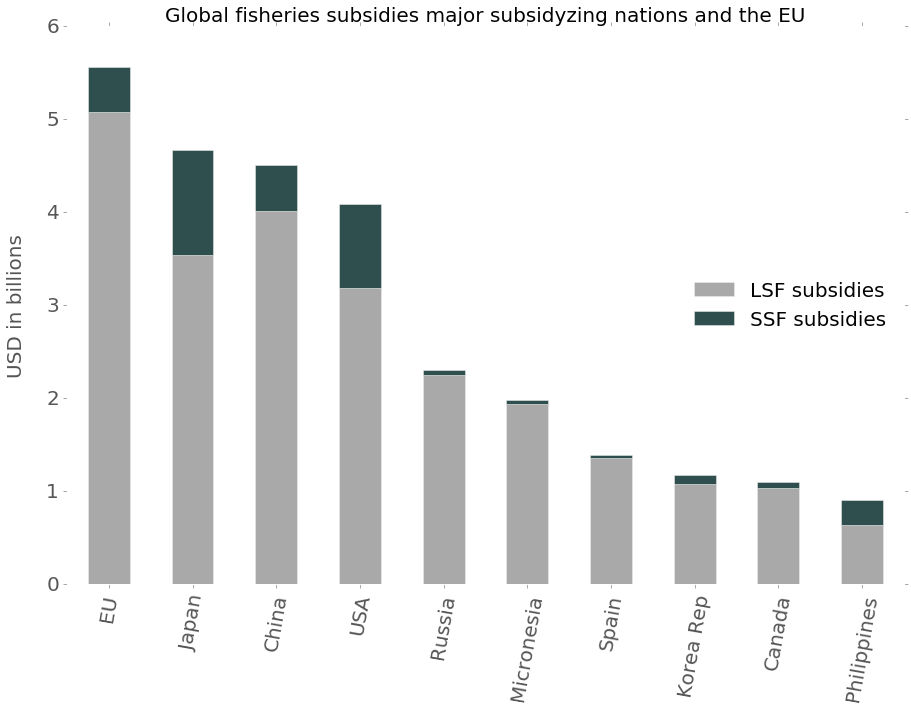

In [61]:
Subsidies_major
ax = Subsidies_major[['LSF subsidies','SSF subsidies']].plot(kind='bar', figsize=(15,10),stacked=True, legend=True, fontsize=20, color=["darkgray","darkslategrey"] )
ax.set_title("Global fisheries subsidies major subsidyzing nations and the EU", fontsize=20)
ax.set_ylabel("USD in billions",fontsize=20)
ax.yaxis.labelpad = 20
ax.set_xlabel("",fontsize=20)
ax.set_xticklabels(['EU','Japan','China','USA','Russia','Micronesia','Spain','Korea Rep','Canada','Philippines'],rotation=80, fontsize=20)

ax.set_axis_bgcolor('w')

legend = plt.legend(loc=5,fontsize=20)
legend.get_frame().set_facecolor('w')

plt.savefig('Subsidies_major.svg', dpi=400, bbox_inches='tight')
plt.savefig('Subsidies_major.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [62]:
Subsidies_countries_major['SSF percent'] = Subsidies_countries_major['SSF subsidies']/Subsidies_countries_major['total_subsidies']*100 

In [63]:
Subsidies_countries_major.transpose()

Countries,Japan,China,USA,Russian Fed,Micronesia,Spain,Korea Rep,Canada,Philippines
total_subsidies,4.670,4.509,4.091,2.300,1.976,1.388,1.180,1.102,0.908
SSF subsidies,1.129,0.498,0.902,0.055,0.038,0.033,0.105,0.063,0.272
LSF subsidies,3.540,4.011,3.189,2.245,1.938,1.355,1.075,1.039,0.636
SSF percent,24.184,11.039,22.046,2.391,1.936,2.388,8.931,5.750,30.002


In [64]:
#  work with SSF_subsidies
#  organize data by data group which is 1,2 or 3 and have frequencies per subytype of all assessed subsidies data
#  this includes 73 countries that have been assessed
print SSF_subsidies.columns.values
Data_group = pd.crosstab(SSF_subsidies.SubType, SSF_subsidies.Data_group)
print Data_group.columns.values
Data_group = Data_group.reset_index()
print Data_group
#  making a new index for the columns to work with the new dataframe
#  Data_group.set_index(['ID','SubType','one','two','three'], verify_integrity=False)

['ID' 'Cnumber' 'RegionID' 'RegionName' 'Type' 'SubType' 'Category'
 'total_subsidies' 'NewData' 'Developed' 'HDI_2005' 'Countries'
 'SSFsubsidies_assessed_percent' 'weighted_by_sectorsize' 'Data_group'
 'SSF_totalCatch_EEZ_percent' '%SSF_totalCatch_Country' 'SSF_USD_1000'
 'Comment' 'DocSource' 'SourceVisitDate' 'Ref' 'URL' 'User' 'OldComment'
 'SSF_subsidies_percent']
[ 1.  2.  3.]
Data_group                    SubType  1.0  2.0  3.0
0           Boat constsruct. & renov.    2   25   16
1                   Fisher assistance    3   11   15
2             Fisheries dev. projects    6   31   20
3                    Fisheries mangt.    2   29   41
4                         Fishery R&D    2   19   37
5                      Fishing access    1   17    0
6               Fishing port develop.    2   12    8
7                      Fuel subsidies   34    1    0
8                                MPAs    0    1   64
9           Markt. & storage infrast.    4   27   19
10           Rural fisher comm

In [65]:
Data_group_percentages = pd.crosstab(SSF_subsidies.SubType, SSF_subsidies.Data_group).apply(lambda r: r/r.sum(), axis=1)
Data_group_percentages

Data_group,1.0,2.0,3.0
SubType,,,
Boat constsruct. & renov.,0.047,0.581,0.372
Fisher assistance,0.103,0.379,0.517
Fisheries dev. projects,0.105,0.544,0.351
Fisheries mangt.,0.028,0.403,0.569
Fishery R&D,0.034,0.328,0.638
Fishing access,0.056,0.944,0.000
Fishing port develop.,0.091,0.545,0.364
Fuel subsidies,0.971,0.029,0.000
MPAs,0.000,0.015,0.985


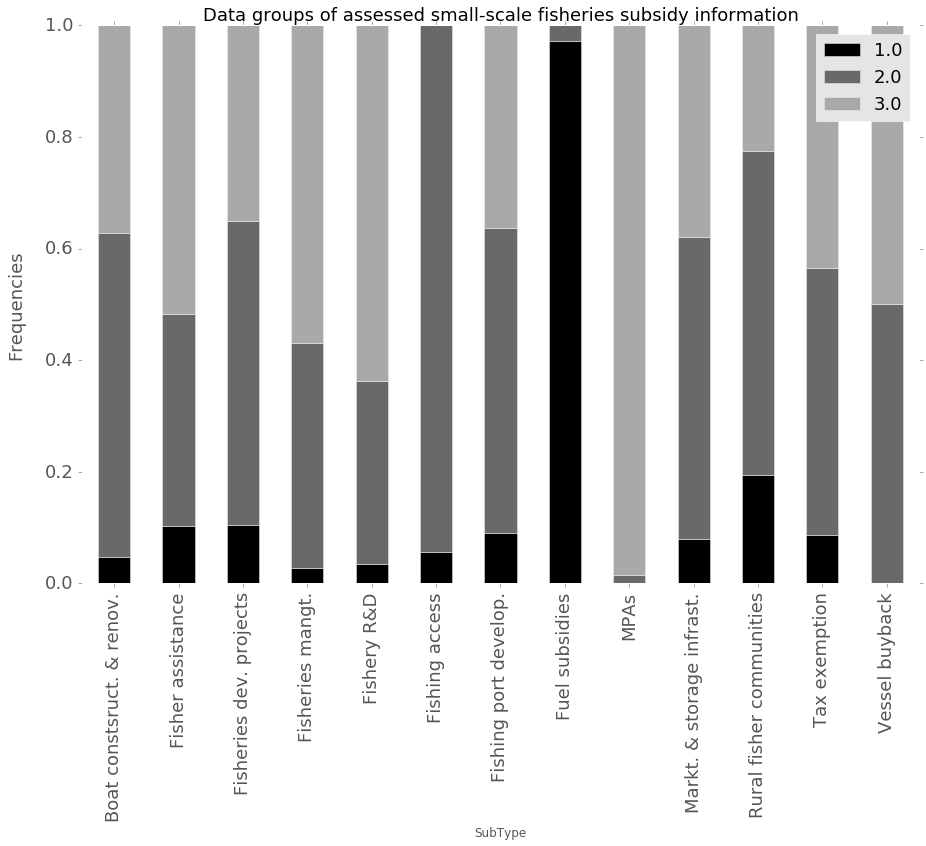

In [66]:
ax = Data_group_percentages.plot(kind='bar', figsize=(15,10), stacked = True, fontsize=18, color=["black","dimgray", "darkgray"])
ax.set_title("Data groups of assessed small-scale fisheries subsidy information", fontsize=18)
ax.set_ylabel("Frequencies",fontsize=18)
ax.yaxis.labelpad = 20
ax.set_axis_bgcolor('w')
plt.legend(loc=1,fontsize=18)

plt.savefig('Data_groups_percentages.svg', dpi=400, bbox_inches='tight')
plt.savefig('Data_groups_percentages.pdf', dpi=400, bbox_inches='tight')
plt.show()

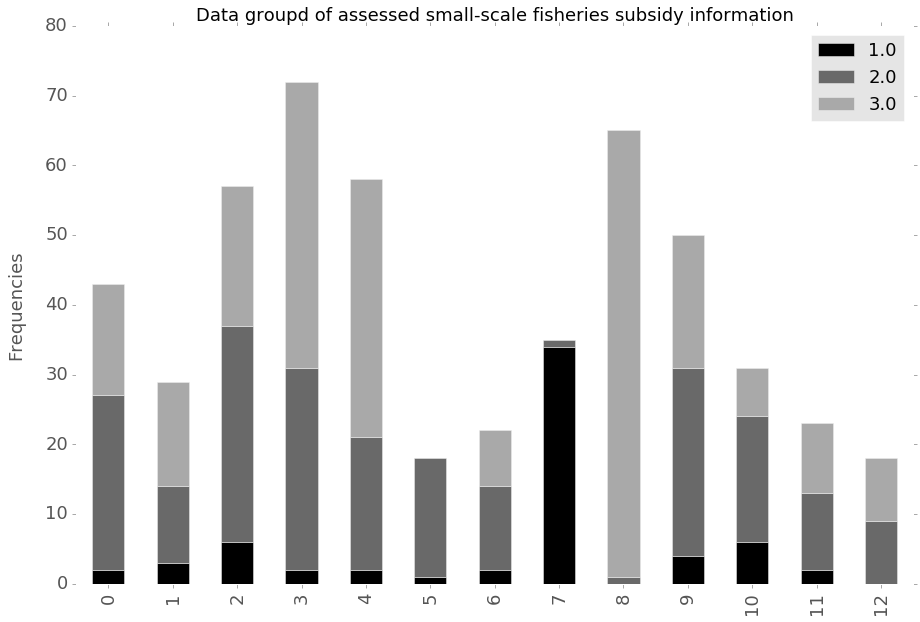

In [67]:
ax = Data_group.plot(kind='bar', figsize=(15,10), stacked = True, fontsize=18, color=["black","dimgray", "darkgray"])
ax.set_title("Data groupd of assessed small-scale fisheries subsidy information", fontsize=18)
ax.set_ylabel("Frequencies",fontsize=18)
ax.yaxis.labelpad = 20
ax.set_axis_bgcolor('w')
plt.legend(loc='best',fontsize=18)

plt.savefig('Data_groups.svg', dpi=400, bbox_inches='tight')
plt.savefig('Data_groups.pdf', dpi=400, bbox_inches='tight')
plt.show()



In [68]:

Subsidies_Data_Table = SSF_subsidies_estimates_assessed.groupby(['Countries','SubType']).sum()
print Subsidies_Data_Table.columns.values
Appendix = Subsidies_Data_Table.loc[:,['SSF subsidies','LSF subsidies','Data_group','SSFsubsidies_assessed_percent']]

['CLon' 'CLat' 'SIDS' 'TotPop' 'HDI' 'Developed' 'GDP' 'EU member' 'EEZ'
 'total_catch' 'total_subsidies' 'SSF_catch_percent' 'SSF_subregion_catch'
 'subsidies_subregion_all' 'Factor' 'SSF_subsidies_estimates'
 'SSF_subsidies_estimates_big' 'SSF_estimates_corrected'
 'SSFsubsidies_assessed_percent' 'Data_group' 'SSF_USD_1000'
 'SSF_subsidies_percent' 'SSF_subsidies_percent_all' 'SSF subsidies'
 'LSF subsidies']


In [69]:
Appendix2_fuel = pd.read_csv("SSF_subsidies_appendix_fuel.csv")

In [70]:
Appendix2 = pd.merge(left=all_subsidies, right=Appendix2_fuel, how='left')


In [71]:
SSF_subsidies_estimates_assessed.to_csv('Appendix2.csv')